### General note for GPU training (in colab)

* First, please use the GPU runtime. If so the `!nvidia-smi` will return no error.
  1. Click on "Runtime" in the top menu bar.
  2. Select "Change runtime type" from the drop-down menu.
  3. In the "Runtime type" section, select "GPU" as the hardware accelerator.
  4. Click "Save" to apply the changes.


* What should I do with **Cuda out of memory error.**? (this is THE mode common error in DL)
![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*enMsxkgJ1eb9XvtWju5V8Q.png)
  1. In colab notebook, **unfortunately, you need to restart the kernel after OOM happened**. Or it will keep happening no matter what.
  2. Change the model to save memory, usually includes, decrease batch size, decrease the number of layers, decrease the max sequence length, decrease the hidden / embedding dimension
  3. If you know mixed precision training, you can switch to low precision `fp16` numbers for weights and inputs.

* What should I do for the **Device siee assert triggered** error
  > RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
  
  * Usually it's because the embedding layer receive an index (token id or position id) not stored in it.
  * Could be sth. else, which will be harder to debug...

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" # to fix a potential locale bug
!nvidia-smi

### Set up library and dataset

* `Pretty-midi` library to read midi files
* `fluidsynth` synthesize midi music to wav, and play on the colab


In [ ]:
!pip install pretty_midi librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=4efe17ae7f9fb8d3d07e9eb04baae9ab07d57433c0b5bdb02678f010c23f2be4
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi


In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

In [ ]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.7 MB/s eta 0:00:00


In [ ]:
!pip install pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Source of data https://magenta.tensorflow.org/datasets/maestro

In [ ]:
maestro_v3_midi_url = "https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip"
maestro_v3_meta_url = "https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.csv"
maestro_v3_json_url = "https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.json"

In [ ]:
!wget $maestro_v3_midi_url
!wget $maestro_v3_meta_url
!wget $maestro_v3_json_url
!unzip -q maestro-v3.0.0-midi.zip

--2023-04-13 04:42:25--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.128, 172.253.119.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M   137MB/s    in 0.4s    

2023-04-13 04:42:25 (137 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]

--2023-04-13 04:42:25--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.128, 172.253.119.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.128|:443... connected.
HTTP request sent, awaiting response... 200 O

### Imports

In [ ]:
import pretty_midi
import librosa.display
import librosa
import os
from os.path import join
from typing import Union
# from tqdm import tqdm, trange
from tqdm.notebook import tqdm, trange
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup
import matplotlib.pylab as plt

### Utils function

In [ ]:
from IPython import display
_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  # Colab specific audio playing utils
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
# visualize the midi file as piano roll
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                 hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                 fmin=pretty_midi.note_number_to_hz(start_pitch))

### Visualize a sample midi file

In [ ]:
maestro_root = r"/content/maestro-v3.0.0"
maestro_meta = pd.read_csv(join(maestro_root,"maestro-v3.0.0.csv"))

In [ ]:
# load sample midi file
midi_file = join(maestro_root, maestro_meta["midi_filename"][0])
midi_data = pretty_midi.PrettyMIDI(midi_file)

In [ ]:
display_audio(midi_data)

<ipython-input-3-d0af1759bf28>:4: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


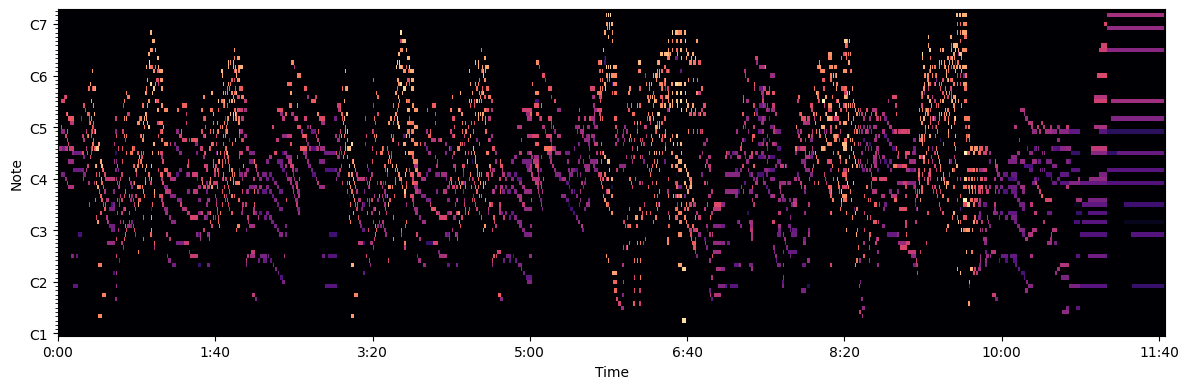

In [ ]:
# create a new figure
fig, ax = plt.subplots(figsize=(12, 4))
# plot the piano roll
plot_piano_roll(midi_data, start_pitch=24, end_pitch=100)
plt.tight_layout()
plt.show()

As you can see, a (single track) midi file is a sequence of notes. So we can imagine using Transformeers to model these sequences so it can write music for us!

In [ ]:
print(midi_data.instruments)
print(len(midi_data.instruments[0].notes))
for i, note in enumerate(midi_data.instruments[0].notes[:30]):
  print(f"pitch={note.pitch} volume={note.velocity} duration={note.duration:.4f} "+
  f"offset={0.0 if i==0 else note.start - midi_data.instruments[0].notes[i-1].end :.4f}")

[Instrument(program=0, is_drum=False, name="")]
4197
pitch=67 volume=52 duration=0.8268 offset=0.0000
pitch=72 volume=67 duration=0.1224 offset=-0.0260
pitch=67 volume=39 duration=0.9792 offset=0.2747
pitch=61 volume=39 duration=1.0651 offset=-0.9818
pitch=78 volume=65 duration=1.4531 offset=-1.0964
pitch=71 volume=45 duration=2.1706 offset=-1.4466
pitch=79 volume=58 duration=0.3203 offset=-0.2253
pitch=79 volume=69 duration=0.3893 offset=0.3255
pitch=70 volume=64 duration=0.4831 offset=-0.3698
pitch=75 volume=70 duration=0.0820 offset=-0.0417
pitch=67 volume=56 duration=0.5482 offset=-0.5091
pitch=60 volume=46 duration=0.6484 offset=-0.5651
pitch=69 volume=61 duration=0.3307 offset=0.1419
pitch=71 volume=69 duration=0.0885 offset=-0.0612
pitch=75 volume=81 duration=0.3841 offset=-0.3685
pitch=67 volume=61 duration=0.4570 offset=-0.3568
pitch=59 volume=56 duration=0.7995 offset=-0.4714
pitch=68 volume=61 duration=0.6497 offset=-0.0299
pitch=67 volume=46 duration=0.0482 offset=-0.0286
p

## Prepare Dataset

In [ ]:
def midi2notes(midi_file: Union[str, pretty_midi.PrettyMIDI]):
    if isinstance(midi_file, str):
        midi_data = pretty_midi.PrettyMIDI(midi_file)
    else:
        midi_data = midi_file

    note_t_seq = []
    note_dt_seq = []
    note_duration_seq = []
    note_velo_seq = []
    note_pitch_seq = []
    prev_note_end = 0.0
    for i, note_sample in enumerate(midi_data.instruments[0].notes[1:]):
        note_dt_seq.append(note_sample.start - prev_note_end)
        note_t_seq.append(note_sample.start)
        note_duration_seq.append(note_sample.duration)
        note_velo_seq.append(note_sample.velocity)
        note_pitch_seq.append(note_sample.pitch)
        prev_note_end = note_sample.end

    note_seq = pd.DataFrame({"t": note_t_seq, "dt": note_dt_seq, "duration": note_duration_seq, "velo": note_velo_seq,
                             "pitch": note_pitch_seq})  # .to_csv("note_seq.csv", index=False)
    return note_seq


In [ ]:
class MusicScoreDataset(torch.utils.data.Dataset):

    def __init__(self, maestro_root, maestro_meta=None, ):
        self.maestro_root = maestro_root
        if maestro_meta is None:
            self.maestro_meta = pd.read_csv(join(maestro_root, "maestro-v3.0.0.csv"))
        else:
            self.maestro_meta = maestro_meta

        self.dataset = {}

    def load_dataset(self):
        notes_cnt = 0
        piece_cnt = 0
        for i in tqdm(range(len(self.maestro_meta))):
            row = self.maestro_meta.iloc[i]
            midi_path = join(self.maestro_root, row["midi_filename"].replace("/", os.path.sep))
            # load sample midi file
            midi_data = pretty_midi.PrettyMIDI(midi_path)
            note_seq = midi2notes(midi_data)
            self.dataset[i] = (row[["canonical_composer", 'canonical_title', 'year', 'duration']], note_seq)
            notes_cnt += len(note_seq)
            piece_cnt += 1
        print(f"{piece_cnt} pieces {notes_cnt} notes")
        return

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        meta, note_seq = self.dataset[idx]
        return meta, note_seq


In [ ]:
dataset = MusicScoreDataset(maestro_root, maestro_meta)

In [ ]:
if os.path.exists(join(maestro_root, "dataset.pkl")):
    dataset.dataset = pickle.load(open(join(maestro_root, "dataset.pkl"), "rb"))

In [ ]:
# dataset.load_dataset()

# pickle.dump(dataset.dataset, open(join(maestro_root, "dataset.pkl"), "wb"))

In [ ]:
# !du -sh /content/maestro-v3.0.0/dataset.pkl

In [ ]:
# !cp /content/maestro-v3.0.0/dataset.pkl /content/drive/MyDrive/TransformerFromScratch

In [ ]:
# !du -sh /content/drive/MyDrive/TransformerFromScratch/dataset.pkl

In [ ]:
# !cp /content/drive/MyDrive/TransformerFromScratch/dataset.pkl /content/maestro-v3.0.0/dataset.pkl

In [ ]:
# pickle.load(open("/content/drive/MyDrive/TransformerFromScratch/dataset.pkl", "rb"))

In [ ]:
# dataset.dataset = pickle.load(open(join(maestro_root, "dataset.pkl"), "rb"))
# dataset.dataset = pickle.load(open("/content/drive/MyDrive/TransformerFromScratch/dataset.pkl", "rb"))

In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [ ]:
token_num = 128 # 128 pitch classes
BOS_id = token_num
EOS_id = token_num + 1
PAD_ID = EOS_id + 1
MASK_LABEL_ID = - 100

def notedf2tensor(note_df, device="cuda"):
    pitch_ids = torch.tensor(note_df.pitch.values).unsqueeze(0).long().to(device)
    velo = torch.tensor(note_df.velo.values).unsqueeze(0).float().to(device) / 128.0
    dur = torch.tensor(note_df.duration.values).unsqueeze(0).float().to(device)
    dt = torch.tensor(note_df.dt.values).unsqueeze(0).float().to(device)
    return pitch_ids, velo, dur, dt


def batch_sampler(data_source, batch_idxs, max_seq_len=1024):
    batch_pitch = []  # integer value
    batch_velo = []  # integer value
    batch_dt = []  # float value
    batch_duration = []  # float value
    label_batch = []
    if isinstance(batch_idxs, int):
        batch_idxs = range(batch_idxs)
    for i in batch_idxs:
        meta, note_seq = data_source[i]
        # sample note sequence with max_seq_len
        if len(note_seq) <= max_seq_len:
            note_seq_subsamp = note_seq
        else:
            seq_start = np.random.randint(0, len(note_seq) - max_seq_len)
            note_seq_subsamp = note_seq.iloc[seq_start:seq_start + max_seq_len]

        pitch, velo, dur, dt = notedf2tensor(note_seq_subsamp, device="cpu")
        batch_pitch.append(pitch[0])
        batch_velo.append(velo[0])
        batch_dt.append(dt[0])
        batch_duration.append(dur[0])

    batch_pitch = pad_sequence(batch_pitch, batch_first=True, padding_value=PAD_ID)
    batch_velo = pad_sequence(batch_velo, batch_first=True, padding_value=0.5)
    batch_dt = pad_sequence(batch_dt, batch_first=True, padding_value=0.0)
    batch_duration = pad_sequence(batch_duration, batch_first=True, padding_value=0.0)
    return batch_pitch, batch_velo, batch_dt, batch_duration

In [ ]:
batch_sampler(dataset, range(5), max_seq_len=256)

(tensor([[58, 42, 51,  ..., 55, 82, 88],
         [55, 63, 62,  ..., 50, 62, 81],
         [74, 77, 65,  ..., 70, 63, 45],
         [49, 37, 68,  ..., 70, 58, 65],
         [71, 85, 66,  ..., 56, 66, 80]]),
 tensor([[0.3203, 0.2969, 0.2578,  ..., 0.6719, 0.7109, 0.0781],
         [0.5547, 0.7109, 0.5625,  ..., 0.7031, 0.7109, 0.7266],
         [0.7188, 0.6953, 0.6719,  ..., 0.4062, 0.3672, 0.4531],
         [0.7266, 0.6016, 0.7188,  ..., 0.6797, 0.4766, 0.5391],
         [0.4844, 0.6172, 0.4297,  ..., 0.1875, 0.3125, 0.5391]]),
 tensor([[-0.8698, -0.2318,  0.6510,  ..., -0.1667, -0.1458, -0.0182],
         [-0.7357, -0.7721, -0.1081,  ...,  0.1406, -0.0521, -0.3047],
         [-0.0906,  0.2531, -0.2479,  ..., -0.1333, -0.4698, -0.6406],
         [ 0.0188, -0.0188, -0.0333,  ...,  0.0073, -0.0885,  0.0167],
         [ 0.0794, -0.0404, -0.1810,  ...,  0.0664,  0.0352, -0.1992]]),
 tensor([[0.9492, 1.2266, 0.3555,  ..., 0.1732, 0.1641, 0.0872],
         [0.7591, 0.8242, 0.2083,  ..., 0.05

## Model Architecture

In [ ]:
class NoteReadoutHeads(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.velocity_head = nn.Sequential(
            nn.Linear(config.n_embd, config.n_embd),
            nn.Tanh(),
            nn.Linear(config.n_embd, 1),
        )
        self.duration_head = nn.Sequential(
            nn.Linear(config.n_embd, config.n_embd),
            nn.Tanh(),
            nn.Linear(config.n_embd, 1),
            nn.Softplus(), # duration should be positive
        )
        self.dt_head = nn.Sequential(
            nn.Linear(config.n_embd, config.n_embd),
            nn.Tanh(),
            nn.Linear(config.n_embd, 1),
        )

    def forward(self, hidden_states):
        velocity = self.velocity_head(hidden_states).squeeze(-1)
        duration = self.duration_head(hidden_states).squeeze(-1)
        dt = self.dt_head(hidden_states).squeeze(-1)
        return velocity, duration, dt


class ScalarEmbedding(nn.Module):
    def __init__(self, config, ):
        super().__init__()
        self.n_embd = config.n_embd
        self.weights = nn.Parameter(torch.randn(1, 1, self.n_embd) * np.sqrt(1 / self.n_embd))

    def forward(self, x):
        return self.weights * x[:, :, None]

## Generation

In [ ]:
def naive_greedy_decode(model, velocity_emb, duration_emb, dt_emb, readout,
                        prompt_ids, prompt_velos, prompt_durations, prompt_dts, max_gen_tokens=500,
                        temperature=None):
    model.eval()
    readout.eval()
    dt_emb.eval()
    duration_emb.eval()
    velocity_emb.eval()
    pitch_embed = model.get_input_embeddings()(prompt_ids)
    velo_embed = velocity_emb(prompt_velos)
    dur_embed = duration_emb(prompt_durations)
    dt_embed = dt_emb(prompt_dts)
    input_embed = pitch_embed + velo_embed + dur_embed + dt_embed
    input_embed_full = input_embed.clone()
    generated_note_seq = []
    with torch.no_grad():
        for i in trange(max_gen_tokens):
            out = model(inputs_embeds=input_embed_full, output_hidden_states=True)
            last_hidden = out.hidden_states[-1]
            last_logits = out.logits[:, -1, :]
            # pred_velos, pred_durations, pred_dts = readout(last_hidden)
            pred_velo, pred_duration, pred_dt = readout(last_hidden[:, -1, :])
            if temperature is None:
                # greedy decoding
                pitch_maxprob = torch.argmax(last_logits, dim=-1)
            else:
                # Sample from the distribution with temperature
                pitch_maxprob = torch.multinomial(F.softmax(last_logits / temperature, dim=-1),
                                                  num_samples=1).squeeze(1)
            input_embed_new = model.get_input_embeddings()(pitch_maxprob) + \
                              velocity_emb(pred_velo.unsqueeze(0)) + \
                              duration_emb(pred_duration.unsqueeze(0)) + \
                              dt_emb(pred_dt.unsqueeze(0))
            generated_note_seq.append((pitch_maxprob, pred_velo, pred_duration, pred_dt))
            input_embed_full = torch.concat((input_embed_full, input_embed_new), dim=1)

    pitch_gen = torch.stack([pitch for pitch, velo, dur, dt in generated_note_seq], dim=1)
    velo_gen = torch.stack([velo for pitch, velo, dur, dt in generated_note_seq], dim=1)
    dur_gen = torch.stack([dur for pitch, velo, dur, dt in generated_note_seq], dim=1)
    dt_gen = torch.stack([dt for pitch, velo, dur, dt in generated_note_seq], dim=1)
    pitch_gen = torch.concat((prompt_ids, pitch_gen), dim=1).cpu()
    velo_gen = torch.concat((prompt_velos, velo_gen), dim=1).cpu()  # this is 0, 1 normalized
    dur_gen = torch.concat((prompt_durations, dur_gen), dim=1).cpu()
    dt_gen = torch.concat((prompt_dts, dt_gen), dim=1).cpu()
    velo_gen = (velo_gen * 128).long()  # convert to integer
    return pitch_gen, velo_gen, dur_gen, dt_gen


def tensor2midi(pitch, velo, dur, dt, savedir, filename, instrument="Acoustic Grand Piano"):
    generated_midi = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program(instrument)
    piano = pretty_midi.Instrument(program=piano_program)
    cur_time = 0
    for i, pitch in enumerate(pitch):
        cur_time = cur_time + dt[i].item()
        note = pretty_midi.Note(velocity=min(127, max(0, velo[i].item())),
                                pitch=min(127, max(0, pitch.item())),
                                start=cur_time, end=cur_time + dur[i].item())
        cur_time = cur_time + dur[i].item()
        piano.notes.append(note)

    generated_midi.instruments.append(piano)
    generated_midi.write(join(savedir, filename))
    return generated_midi

## Training

In [ ]:
!nvidia-smi

Thu Apr 13 05:57:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(maestro_meta.iloc[20])
prompt_piece = midi2notes(join(maestro_root, maestro_meta["midi_filename"][20].replace("/", os.path.sep)))

canonical_composer                                   Alexander Scriabin
canonical_title        Sonata No. 2 in G-sharp Minor, Op. 19 (Complete)
split                                                             train
year                                                               2017
midi_filename         2017/MIDI-Unprocessed_079_PIANO079_MID--AUDIO-...
audio_filename        2017/MIDI-Unprocessed_079_PIANO079_MID--AUDIO-...
duration                                                      661.90915
Name: 20, dtype: object


In [ ]:
saveroot = "/content/Maestro-GPT" #"runs"

config = GPT2Config(n_embd=128, n_layer=24, n_head=8, n_positions=256,
                    vocab_size=132, bos_token_id=BOS_id, eos_token_id=EOS_id, )
# config = GPT2Config(n_embd=128, n_layer=18, n_head=8, n_positions=256,
#                     vocab_size=token_num + 4, bos_token_id=BOS_id, eos_token_id=EOS_id, )
# config = GPT2Config(n_embd=128, n_layer=36, n_head=8, n_positions=256,
#                     vocab_size=token_num + 4, bos_token_id=BOS_id, eos_token_id=EOS_id, )
model = GPT2LMHeadModel(config)
readout = NoteReadoutHeads(config).cuda()
dt_emb = ScalarEmbedding(config).cuda()
duration_emb = ScalarEmbedding(config).cuda()
velocity_emb = ScalarEmbedding(config).cuda()
model.cuda()
optimizer = AdamW([*model.parameters(),
                   *readout.parameters(),
                   *dt_emb.parameters(),
                   *duration_emb.parameters(),
                   *velocity_emb.parameters(),
                   ], lr=10e-4)
savedir = join(saveroot, "runs_L24")
# savedir = join(saveroot, "runs_L18")
os.makedirs(savedir, exist_ok=True)
os.makedirs(join(savedir, "ckpt"), exist_ok=True)
# %%
max_seq_len = 256
save_per_epoch = 10
synth_per_epoch = 10
batch_size = 24
n_epochs = 200
n_warmup_epochs = 0
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_epochs, n_epochs)
writer = SummaryWriter(savedir)
for epoch in trange(0, n_epochs):

    for module in [model, velocity_emb, duration_emb, dt_emb, readout]:
        module.train()

    rand_idx_seq = np.random.permutation(len(dataset))
    for i, csr in enumerate(trange(0, len(dataset), batch_size)):
        batch_idxs = rand_idx_seq[csr:csr + batch_size]
        batch_pitch, batch_velo, batch_dt, batch_duration = batch_sampler(dataset,
                                                      batch_idxs, max_seq_len=max_seq_len)
        pitch_embed = model.transformer.wte(batch_pitch.cuda())
        note_embed = pitch_embed + velocity_emb(batch_velo.cuda()) + \
            dt_emb(batch_dt.cuda()) + duration_emb(batch_duration.cuda())  #

        # out = model(batch_pitch.cuda(), labels=batch_pitch.cuda(), output_hidden_states=True)
        out = model(inputs_embeds=note_embed, labels=batch_pitch.cuda(), output_hidden_states=True)
        loss = out.loss # categorical cross entropy loss for
        last_hidden = out.hidden_states[-1]  # (batch, seq_len, embd)
        velocity_pred, duration_pred, dt_pred = readout(last_hidden)
        # note we need to predict the next note so shift by 1
        loss_velo = F.mse_loss(velocity_pred[:, :-1], batch_velo.cuda()[:, 1:])
        loss_duration = F.mse_loss(duration_pred[:, :-1], batch_duration.cuda()[:, 1:])
        loss_dt = F.mse_loss(dt_pred[:, :-1], batch_dt.cuda()[:, 1:])
        loss += loss_velo + loss_duration + loss_dt
        # compute additional loss based on last hidden state
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(
            f"epoch{epoch}-step{i:03d} {loss.item():.5f} vel {loss_velo.item():.5f} dur {loss_duration.item():.5f} dt {loss_dt.item():.5f}")
        writer.add_scalar("loss", loss.item(), epoch * len(dataset) // batch_size + i)
        writer.add_scalar("loss_velo", loss_velo.item(), epoch * len(dataset) // batch_size + i)
        writer.add_scalar("loss_duration", loss_duration.item(), epoch * len(dataset) // batch_size + i)
        writer.add_scalar("loss_dt", loss_dt.item(), epoch * len(dataset) // batch_size + i)
        writer.add_scalar("lr", optimizer.param_groups[0]["lr"], epoch * len(dataset) // batch_size + i)
        writer.add_scalar("epoch", epoch, epoch * len(dataset) // batch_size + i)
        # writer.add_scalar("grad_norm", torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0),)
    scheduler.step()
    if epoch % save_per_epoch == 0:
        torch.save(model.state_dict(), join(savedir, "ckpt", f"model_{epoch:03d}.pt"))
        torch.save(readout.state_dict(), join(savedir, "ckpt", f"readout_{epoch:03d}.pt"))
        torch.save(dt_emb.state_dict(), join(savedir, "ckpt", f"dt_emb_{epoch:03d}.pt"))
        torch.save(duration_emb.state_dict(), join(savedir, "ckpt", f"duration_emb_{epoch:03d}.pt"))
        torch.save(velocity_emb.state_dict(), join(savedir, "ckpt", f"velocity_emb_{epoch:03d}.pt"))

    if epoch % synth_per_epoch == 0:
        for module in [model, velocity_emb, duration_emb, dt_emb, readout]:
            module.eval()
        prompt_ids, prompt_velos, prompt_durations, prompt_dts = notedf2tensor(prompt_piece[:10], device="cuda")
        pitch_gen, velo_gen, dur_gen, dt_gen = naive_greedy_decode(model,
                       velocity_emb, duration_emb, dt_emb, readout,
                       prompt_ids, prompt_velos, prompt_durations, prompt_dts,
                        temperature=.2, max_gen_tokens=max_seq_len - 12)
        tensor2midi(pitch_gen[0], velo_gen[0], dur_gen[0], dt_gen[0],
                    savedir, f"generated_midi_with_tempo_T02_{epoch:03d}.mid")


torch.save(readout.state_dict(), join(savedir, "ckpt", f"readout_{epoch:03d}.pt"))
torch.save(dt_emb.state_dict(), join(savedir, "ckpt", f"dt_emb_{epoch:03d}.pt"))
torch.save(duration_emb.state_dict(), join(savedir, "ckpt", f"duration_emb_{epoch:03d}.pt"))
torch.save(velocity_emb.state_dict(), join(savedir, "ckpt", f"velocity_emb_{epoch:03d}.pt"))
model.save_pretrained(join(savedir, "ckpt", f"model_{epoch:03d}.pt"))
config.save_pretrained(join(savedir, "ckpt","config.json"))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch0-step000 5.76733 vel 0.27319 dur 0.28564 dt 0.34705
epoch0-step001 8.14143 vel 1.76245 dur 0.25326 dt 1.26993
epoch0-step002 7.45357 vel 1.30173 dur 0.16950 dt 1.04624
epoch0-step003 5.20563 vel 0.03424 dur 0.25782 dt 0.20320
epoch0-step004 4.90755 vel 0.04841 dur 0.12374 dt 0.12348
epoch0-step005 4.77597 vel 0.02116 dur 0.11333 dt 0.10380
epoch0-step006 4.64652 vel 0.02169 dur 0.05780 dt 0.06161
epoch0-step007 4.76262 vel 0.03102 dur 0.15989 dt 0.17642
epoch0-step008 4.86036 vel 0.04731 dur 0.23368 dt 0.24557
epoch0-step009 4.55250 vel 0.06117 dur 0.07654 dt 0.08408
epoch0-step010 4.54680 vel 0.04902 dur 0.11708 dt 0.11874
epoch0-step011 4.81157 vel 0.02915 dur 0.29404 dt 0.28098
epoch0-step012 4.58194 vel 0.02782 dur 0.16569 dt 0.15127
epoch0-step013 4.69745 vel 0.01889 dur 0.28447 dt 0.26416
epoch0-step014 4.43867 vel 0.02241 dur 0.14728 dt 0.15506
epoch0-step015 4.49771 vel 0.02347 dur 0.13456 dt 0.15603
epoch0-step016 4.67300 vel 0.03274 dur 0.20832 dt 0.22493
epoch0-step017

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch1-step000 4.19685 vel 0.02325 dur 0.06141 dt 0.06725
epoch1-step001 4.67800 vel 0.02117 dur 0.29895 dt 0.31471
epoch1-step002 4.36461 vel 0.02084 dur 0.19553 dt 0.16972
epoch1-step003 6.36877 vel 0.02388 dur 1.22261 dt 1.12917
epoch1-step004 4.20241 vel 0.01850 dur 0.09980 dt 0.10286
epoch1-step005 4.24536 vel 0.01908 dur 0.10722 dt 0.11118
epoch1-step006 4.26807 vel 0.02043 dur 0.08538 dt 0.09949
epoch1-step007 4.44151 vel 0.02094 dur 0.19592 dt 0.17404
epoch1-step008 4.07892 vel 0.01900 dur 0.07258 dt 0.07819
epoch1-step009 4.33286 vel 0.02143 dur 0.14073 dt 0.19679
epoch1-step010 4.30251 vel 0.02065 dur 0.11017 dt 0.12675
epoch1-step011 4.27223 vel 0.02010 dur 0.10429 dt 0.10451
epoch1-step012 4.42932 vel 0.02348 dur 0.20845 dt 0.20342
epoch1-step013 4.24981 vel 0.01754 dur 0.09546 dt 0.09920
epoch1-step014 4.25071 vel 0.02031 dur 0.08338 dt 0.09557
epoch1-step015 4.19463 vel 0.02247 dur 0.06624 dt 0.07095
epoch1-step016 4.14415 vel 0.01895 dur 0.10704 dt 0.10633
epoch1-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch2-step000 4.42346 vel 0.02354 dur 0.17089 dt 0.16149
epoch2-step001 4.51724 vel 0.01928 dur 0.28203 dt 0.24401
epoch2-step002 5.38145 vel 0.02063 dur 0.70655 dt 0.67396
epoch2-step003 4.25157 vel 0.01949 dur 0.07844 dt 0.07746
epoch2-step004 4.26079 vel 0.02108 dur 0.10649 dt 0.10827
epoch2-step005 4.56439 vel 0.01897 dur 0.23926 dt 0.24804
epoch2-step006 4.32102 vel 0.01981 dur 0.13091 dt 0.11587
epoch2-step007 4.41344 vel 0.01925 dur 0.18107 dt 0.17750
epoch2-step008 4.30963 vel 0.01981 dur 0.15948 dt 0.15552
epoch2-step009 4.34796 vel 0.02452 dur 0.12629 dt 0.12788
epoch2-step010 4.24570 vel 0.01966 dur 0.05742 dt 0.06236
epoch2-step011 4.27611 vel 0.01792 dur 0.10564 dt 0.09776
epoch2-step012 4.21932 vel 0.01843 dur 0.09796 dt 0.09972
epoch2-step013 4.34386 vel 0.02022 dur 0.11152 dt 0.16606
epoch2-step014 4.28377 vel 0.02303 dur 0.12045 dt 0.12476
epoch2-step015 4.44486 vel 0.02180 dur 0.24350 dt 0.20309
epoch2-step016 4.30999 vel 0.02356 dur 0.10085 dt 0.12619
epoch2-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch3-step000 4.52142 vel 0.03952 dur 0.25039 dt 0.19484
epoch3-step001 4.48438 vel 0.02471 dur 0.23907 dt 0.19544
epoch3-step002 4.42122 vel 0.02006 dur 0.21180 dt 0.17512
epoch3-step003 4.16780 vel 0.02083 dur 0.05292 dt 0.05426
epoch3-step004 4.25095 vel 0.02302 dur 0.10532 dt 0.09245
epoch3-step005 4.36637 vel 0.02510 dur 0.11503 dt 0.10456
epoch3-step006 4.48123 vel 0.02259 dur 0.22488 dt 0.18101
epoch3-step007 4.37413 vel 0.01704 dur 0.17781 dt 0.13533
epoch3-step008 4.33001 vel 0.02456 dur 0.08597 dt 0.08238
epoch3-step009 4.23408 vel 0.02172 dur 0.08771 dt 0.08694
epoch3-step010 4.44436 vel 0.02063 dur 0.19381 dt 0.19322
epoch3-step011 4.18126 vel 0.01805 dur 0.09872 dt 0.08735
epoch3-step012 4.16896 vel 0.01744 dur 0.07847 dt 0.07662
epoch3-step013 5.71553 vel 0.02259 dur 0.86613 dt 0.78063
epoch3-step014 4.28327 vel 0.02041 dur 0.09569 dt 0.09636
epoch3-step015 4.22211 vel 0.02251 dur 0.11942 dt 0.10318
epoch3-step016 4.31401 vel 0.01800 dur 0.16658 dt 0.14939
epoch3-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch4-step000 4.58962 vel 0.01878 dur 0.31156 dt 0.27749
epoch4-step001 4.26527 vel 0.02093 dur 0.15598 dt 0.13475
epoch4-step002 4.46224 vel 0.02060 dur 0.16114 dt 0.15689
epoch4-step003 4.20958 vel 0.01536 dur 0.07857 dt 0.11382
epoch4-step004 4.56224 vel 0.02002 dur 0.24581 dt 0.23364
epoch4-step005 4.40781 vel 0.02045 dur 0.16070 dt 0.18970
epoch4-step006 4.35034 vel 0.02144 dur 0.18084 dt 0.15150
epoch4-step007 4.32742 vel 0.01846 dur 0.12630 dt 0.11729
epoch4-step008 4.15340 vel 0.01862 dur 0.06949 dt 0.06103
epoch4-step009 4.27322 vel 0.01707 dur 0.12491 dt 0.11790
epoch4-step010 4.40494 vel 0.01760 dur 0.18224 dt 0.15253
epoch4-step011 4.39491 vel 0.01784 dur 0.20826 dt 0.20118
epoch4-step012 4.18010 vel 0.01833 dur 0.08856 dt 0.09879
epoch4-step013 4.36292 vel 0.01675 dur 0.15429 dt 0.15606
epoch4-step014 4.16594 vel 0.01620 dur 0.06549 dt 0.07262
epoch4-step015 4.21887 vel 0.01701 dur 0.14106 dt 0.12972
epoch4-step016 4.24115 vel 0.02217 dur 0.08699 dt 0.07810
epoch4-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch5-step000 4.19149 vel 0.01672 dur 0.11822 dt 0.12797
epoch5-step001 4.33984 vel 0.01662 dur 0.17737 dt 0.19030
epoch5-step002 4.22037 vel 0.01740 dur 0.07660 dt 0.09091
epoch5-step003 4.30627 vel 0.01654 dur 0.15182 dt 0.18410
epoch5-step004 4.32979 vel 0.01640 dur 0.12412 dt 0.14215
epoch5-step005 4.22553 vel 0.01963 dur 0.04219 dt 0.05660
epoch5-step006 4.17324 vel 0.01909 dur 0.07638 dt 0.08989
epoch5-step007 4.31061 vel 0.01636 dur 0.14959 dt 0.17528
epoch5-step008 4.21177 vel 0.01918 dur 0.07208 dt 0.08315
epoch5-step009 4.50953 vel 0.01675 dur 0.19595 dt 0.28802
epoch5-step010 4.38317 vel 0.01774 dur 0.13087 dt 0.21039
epoch5-step011 4.07616 vel 0.01664 dur 0.05210 dt 0.05979
epoch5-step012 4.26786 vel 0.01782 dur 0.10047 dt 0.11501
epoch5-step013 4.22587 vel 0.01801 dur 0.07798 dt 0.09204
epoch5-step014 4.16987 vel 0.02010 dur 0.04393 dt 0.06018
epoch5-step015 4.14804 vel 0.01910 dur 0.06532 dt 0.07835
epoch5-step016 4.13643 vel 0.01658 dur 0.07964 dt 0.09205
epoch5-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch6-step000 4.33665 vel 0.01902 dur 0.16225 dt 0.24120
epoch6-step001 4.54930 vel 0.02423 dur 0.21930 dt 0.25566
epoch6-step002 4.19719 vel 0.01746 dur 0.08172 dt 0.08391
epoch6-step003 4.19396 vel 0.01738 dur 0.13137 dt 0.13858
epoch6-step004 4.16479 vel 0.01903 dur 0.08424 dt 0.09153
epoch6-step005 4.15984 vel 0.01936 dur 0.07557 dt 0.12116
epoch6-step006 4.24218 vel 0.01970 dur 0.11352 dt 0.11552
epoch6-step007 4.08218 vel 0.01865 dur 0.05217 dt 0.07175
epoch6-step008 4.29975 vel 0.01682 dur 0.14531 dt 0.17434
epoch6-step009 4.56123 vel 0.02115 dur 0.26477 dt 0.32357
epoch6-step010 4.26348 vel 0.02067 dur 0.14164 dt 0.16408
epoch6-step011 4.14271 vel 0.02292 dur 0.10395 dt 0.11821
epoch6-step012 4.13283 vel 0.01942 dur 0.09883 dt 0.13462
epoch6-step013 4.12465 vel 0.02041 dur 0.09273 dt 0.10583
epoch6-step014 4.13350 vel 0.01817 dur 0.06595 dt 0.07606
epoch6-step015 4.09603 vel 0.01648 dur 0.07976 dt 0.08834
epoch6-step016 4.32116 vel 0.01877 dur 0.10125 dt 0.19260
epoch6-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch7-step000 4.26576 vel 0.01698 dur 0.17361 dt 0.19482
epoch7-step001 4.33262 vel 0.01846 dur 0.20495 dt 0.22718
epoch7-step002 4.25918 vel 0.01672 dur 0.12678 dt 0.14307
epoch7-step003 4.19484 vel 0.01586 dur 0.13533 dt 0.15077
epoch7-step004 4.18329 vel 0.01837 dur 0.11725 dt 0.15049
epoch7-step005 4.11902 vel 0.01918 dur 0.07132 dt 0.07911
epoch7-step006 4.15755 vel 0.01775 dur 0.10788 dt 0.11256
epoch7-step007 4.33014 vel 0.01847 dur 0.15044 dt 0.16688
epoch7-step008 4.15696 vel 0.01897 dur 0.05710 dt 0.07171
epoch7-step009 4.19919 vel 0.01729 dur 0.12627 dt 0.12794
epoch7-step010 4.08837 vel 0.01729 dur 0.12081 dt 0.11943
epoch7-step011 4.27699 vel 0.01752 dur 0.16845 dt 0.16530
epoch7-step012 4.18563 vel 0.01669 dur 0.09715 dt 0.11212
epoch7-step013 4.12624 vel 0.01862 dur 0.08021 dt 0.11023
epoch7-step014 4.21439 vel 0.01694 dur 0.10461 dt 0.15768
epoch7-step015 4.14788 vel 0.01627 dur 0.06169 dt 0.07383
epoch7-step016 5.01152 vel 0.01878 dur 0.53395 dt 0.57836
epoch7-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch8-step000 4.33121 vel 0.01665 dur 0.21233 dt 0.23930
epoch8-step001 4.33087 vel 0.01836 dur 0.16609 dt 0.22148
epoch8-step002 4.10249 vel 0.01958 dur 0.08989 dt 0.10125
epoch8-step003 4.43152 vel 0.02247 dur 0.22935 dt 0.25105
epoch8-step004 4.04143 vel 0.01850 dur 0.08169 dt 0.08533
epoch8-step005 4.23231 vel 0.01950 dur 0.13628 dt 0.14448
epoch8-step006 4.15110 vel 0.02248 dur 0.04795 dt 0.06300
epoch8-step007 4.09211 vel 0.01792 dur 0.07381 dt 0.09150
epoch8-step008 4.06538 vel 0.01581 dur 0.09624 dt 0.10342
epoch8-step009 4.10208 vel 0.01470 dur 0.09301 dt 0.11343
epoch8-step010 4.29177 vel 0.02026 dur 0.15704 dt 0.18137
epoch8-step011 4.03416 vel 0.01875 dur 0.07229 dt 0.08014
epoch8-step012 4.01054 vel 0.01882 dur 0.07205 dt 0.08942
epoch8-step013 4.24173 vel 0.01893 dur 0.07459 dt 0.08633
epoch8-step014 4.09599 vel 0.01591 dur 0.07738 dt 0.08774
epoch8-step015 4.13407 vel 0.01641 dur 0.11531 dt 0.12573
epoch8-step016 4.20845 vel 0.01843 dur 0.12362 dt 0.14685
epoch8-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch9-step000 4.04280 vel 0.01711 dur 0.04279 dt 0.04862
epoch9-step001 4.01792 vel 0.02189 dur 0.08517 dt 0.09709
epoch9-step002 4.02186 vel 0.01720 dur 0.07239 dt 0.07556
epoch9-step003 4.06491 vel 0.01804 dur 0.08248 dt 0.09355
epoch9-step004 4.19132 vel 0.01791 dur 0.15604 dt 0.19264
epoch9-step005 4.31613 vel 0.01672 dur 0.21262 dt 0.23569
epoch9-step006 4.16707 vel 0.01869 dur 0.09453 dt 0.10087
epoch9-step007 4.10452 vel 0.01674 dur 0.12676 dt 0.12925
epoch9-step008 4.23156 vel 0.01960 dur 0.12980 dt 0.13930
epoch9-step009 4.04519 vel 0.02058 dur 0.09925 dt 0.10417
epoch9-step010 4.15580 vel 0.01846 dur 0.12092 dt 0.13120
epoch9-step011 3.99161 vel 0.01686 dur 0.07294 dt 0.09103
epoch9-step012 4.02829 vel 0.02031 dur 0.04343 dt 0.05079
epoch9-step013 4.23155 vel 0.02012 dur 0.15530 dt 0.17125
epoch9-step014 4.27146 vel 0.01938 dur 0.15243 dt 0.15633
epoch9-step015 4.15648 vel 0.01637 dur 0.11272 dt 0.15775
epoch9-step016 4.05389 vel 0.01843 dur 0.05337 dt 0.06413
epoch9-step017

  0%|          | 0/54 [00:00<?, ?it/s]

epoch10-step000 4.19505 vel 0.01804 dur 0.11139 dt 0.13568
epoch10-step001 4.14774 vel 0.01668 dur 0.09839 dt 0.11404
epoch10-step002 4.08025 vel 0.01998 dur 0.07266 dt 0.07477
epoch10-step003 4.08000 vel 0.01817 dur 0.09244 dt 0.10117
epoch10-step004 4.20250 vel 0.01819 dur 0.15293 dt 0.16561
epoch10-step005 4.36746 vel 0.01871 dur 0.20515 dt 0.22157
epoch10-step006 4.37156 vel 0.02141 dur 0.21393 dt 0.21628
epoch10-step007 4.19184 vel 0.01946 dur 0.13938 dt 0.16302
epoch10-step008 4.05401 vel 0.01957 dur 0.08257 dt 0.09574
epoch10-step009 4.07281 vel 0.01968 dur 0.06906 dt 0.08098
epoch10-step010 4.28539 vel 0.01906 dur 0.15165 dt 0.16385
epoch10-step011 4.03182 vel 0.01723 dur 0.08816 dt 0.11385
epoch10-step012 4.20692 vel 0.02027 dur 0.14461 dt 0.17143
epoch10-step013 4.17145 vel 0.01950 dur 0.09736 dt 0.11258
epoch10-step014 4.29026 vel 0.01963 dur 0.19328 dt 0.22732
epoch10-step015 4.08926 vel 0.01662 dur 0.06590 dt 0.08267
epoch10-step016 4.10619 vel 0.01587 dur 0.11131 dt 0.119

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch11-step000 4.15345 vel 0.01813 dur 0.10243 dt 0.10014
epoch11-step001 4.10679 vel 0.01975 dur 0.09502 dt 0.09824
epoch11-step002 4.16658 vel 0.02025 dur 0.14182 dt 0.13589
epoch11-step003 3.98315 vel 0.01614 dur 0.06690 dt 0.07433
epoch11-step004 3.94569 vel 0.01528 dur 0.05704 dt 0.06864
epoch11-step005 4.27657 vel 0.02538 dur 0.16586 dt 0.18938
epoch11-step006 4.18960 vel 0.02293 dur 0.14196 dt 0.16433
epoch11-step007 4.07207 vel 0.01802 dur 0.07148 dt 0.08302
epoch11-step008 4.05903 vel 0.01885 dur 0.10659 dt 0.13107
epoch11-step009 4.45456 vel 0.01788 dur 0.11935 dt 0.39271
epoch11-step010 4.05385 vel 0.01750 dur 0.05245 dt 0.06241
epoch11-step011 4.23714 vel 0.01676 dur 0.16504 dt 0.19636
epoch11-step012 4.40161 vel 0.02055 dur 0.21571 dt 0.22100
epoch11-step013 4.06352 vel 0.01612 dur 0.06823 dt 0.07808
epoch11-step014 3.99889 vel 0.01785 dur 0.08367 dt 0.08966
epoch11-step015 4.10190 vel 0.01784 dur 0.11050 dt 0.12812
epoch11-step016 4.20300 vel 0.01914 dur 0.12302 dt 0.137

  0%|          | 0/54 [00:00<?, ?it/s]

epoch12-step000 4.08016 vel 0.01751 dur 0.10330 dt 0.11824
epoch12-step001 4.23814 vel 0.02187 dur 0.14168 dt 0.19630
epoch12-step002 4.12681 vel 0.02108 dur 0.09151 dt 0.10782
epoch12-step003 4.18574 vel 0.02088 dur 0.08625 dt 0.14813
epoch12-step004 4.37768 vel 0.01630 dur 0.23122 dt 0.26482
epoch12-step005 4.22424 vel 0.01877 dur 0.16037 dt 0.23379
epoch12-step006 4.15068 vel 0.02475 dur 0.10308 dt 0.11894
epoch12-step007 4.11506 vel 0.02052 dur 0.09309 dt 0.09572
epoch12-step008 4.05539 vel 0.01780 dur 0.07617 dt 0.08950
epoch12-step009 4.01520 vel 0.01986 dur 0.06790 dt 0.06721
epoch12-step010 4.04519 vel 0.01928 dur 0.09976 dt 0.09986
epoch12-step011 4.10086 vel 0.01809 dur 0.09148 dt 0.10848
epoch12-step012 4.54514 vel 0.01886 dur 0.32770 dt 0.36933
epoch12-step013 4.06175 vel 0.01797 dur 0.12596 dt 0.12404
epoch12-step014 4.09697 vel 0.02226 dur 0.09835 dt 0.11600
epoch12-step015 4.03369 vel 0.01840 dur 0.07890 dt 0.09196
epoch12-step016 4.09326 vel 0.01529 dur 0.10470 dt 0.117

  0%|          | 0/54 [00:00<?, ?it/s]

epoch13-step000 4.19485 vel 0.02030 dur 0.16760 dt 0.16855
epoch13-step001 3.97022 vel 0.01806 dur 0.07859 dt 0.07740
epoch13-step002 4.26470 vel 0.01795 dur 0.13884 dt 0.16682
epoch13-step003 4.16645 vel 0.01933 dur 0.12364 dt 0.13134
epoch13-step004 4.05507 vel 0.01819 dur 0.09807 dt 0.10413
epoch13-step005 3.93775 vel 0.01699 dur 0.04587 dt 0.04892
epoch13-step006 4.11124 vel 0.01588 dur 0.11362 dt 0.12452
epoch13-step007 4.09169 vel 0.01698 dur 0.10294 dt 0.11381
epoch13-step008 4.14917 vel 0.01595 dur 0.15445 dt 0.17482
epoch13-step009 4.13641 vel 0.02007 dur 0.13352 dt 0.14315
epoch13-step010 4.05336 vel 0.01941 dur 0.06328 dt 0.07275
epoch13-step011 3.94329 vel 0.01435 dur 0.07066 dt 0.07413
epoch13-step012 4.09835 vel 0.01982 dur 0.11771 dt 0.11623
epoch13-step013 3.96976 vel 0.01541 dur 0.09099 dt 0.10150
epoch13-step014 4.05706 vel 0.01986 dur 0.06348 dt 0.06879
epoch13-step015 4.08591 vel 0.01807 dur 0.09072 dt 0.09828
epoch13-step016 4.22251 vel 0.02145 dur 0.13458 dt 0.155

  0%|          | 0/54 [00:00<?, ?it/s]

epoch14-step000 4.10676 vel 0.02114 dur 0.07941 dt 0.10464
epoch14-step001 4.21005 vel 0.02554 dur 0.15934 dt 0.18268
epoch14-step002 4.27789 vel 0.02290 dur 0.16040 dt 0.19808
epoch14-step003 4.08707 vel 0.02015 dur 0.09667 dt 0.12182
epoch14-step004 4.17218 vel 0.02158 dur 0.11566 dt 0.09309
epoch14-step005 4.07850 vel 0.01949 dur 0.07117 dt 0.08327
epoch14-step006 4.04175 vel 0.02450 dur 0.10468 dt 0.11421
epoch14-step007 4.04010 vel 0.01749 dur 0.08347 dt 0.09441
epoch14-step008 4.06727 vel 0.02177 dur 0.08655 dt 0.10210
epoch14-step009 4.05652 vel 0.01768 dur 0.10269 dt 0.11682
epoch14-step010 4.02942 vel 0.01849 dur 0.07758 dt 0.08404
epoch14-step011 4.11587 vel 0.02063 dur 0.11122 dt 0.12989
epoch14-step012 3.94774 vel 0.01850 dur 0.06324 dt 0.07370
epoch14-step013 4.03273 vel 0.01799 dur 0.09513 dt 0.09754
epoch14-step014 4.02798 vel 0.01725 dur 0.09270 dt 0.14116
epoch14-step015 4.22608 vel 0.02003 dur 0.16429 dt 0.20683
epoch14-step016 3.97335 vel 0.01756 dur 0.06429 dt 0.085

  0%|          | 0/54 [00:00<?, ?it/s]

epoch15-step000 4.10271 vel 0.01843 dur 0.08525 dt 0.08798
epoch15-step001 3.90703 vel 0.01873 dur 0.07655 dt 0.09068
epoch15-step002 4.20188 vel 0.01678 dur 0.12027 dt 0.14659
epoch15-step003 4.08323 vel 0.01942 dur 0.12211 dt 0.13955
epoch15-step004 3.93342 vel 0.01566 dur 0.09039 dt 0.09909
epoch15-step005 3.92443 vel 0.01661 dur 0.07389 dt 0.08605
epoch15-step006 3.99752 vel 0.01481 dur 0.05995 dt 0.07119
epoch15-step007 3.85135 vel 0.01699 dur 0.04983 dt 0.05146
epoch15-step008 4.09724 vel 0.02129 dur 0.16114 dt 0.17472
epoch15-step009 4.21562 vel 0.01750 dur 0.17644 dt 0.23223
epoch15-step010 4.21194 vel 0.01786 dur 0.17452 dt 0.22456
epoch15-step011 4.01221 vel 0.02246 dur 0.08608 dt 0.11358
epoch15-step012 4.19128 vel 0.02126 dur 0.11572 dt 0.14749
epoch15-step013 4.01754 vel 0.01690 dur 0.08706 dt 0.10168
epoch15-step014 4.04950 vel 0.01681 dur 0.07492 dt 0.11633
epoch15-step015 4.04215 vel 0.02060 dur 0.09741 dt 0.11667
epoch15-step016 4.01315 vel 0.02093 dur 0.07924 dt 0.093

  0%|          | 0/54 [00:00<?, ?it/s]

epoch16-step000 4.04739 vel 0.01635 dur 0.10285 dt 0.11292
epoch16-step001 3.97975 vel 0.01884 dur 0.06418 dt 0.07586
epoch16-step002 3.98009 vel 0.01602 dur 0.09275 dt 0.11130
epoch16-step003 3.95909 vel 0.01636 dur 0.10372 dt 0.11424
epoch16-step004 4.05885 vel 0.01789 dur 0.11068 dt 0.11880
epoch16-step005 3.88659 vel 0.01789 dur 0.04979 dt 0.06300
epoch16-step006 3.95143 vel 0.02009 dur 0.10741 dt 0.11022
epoch16-step007 4.06421 vel 0.01650 dur 0.14444 dt 0.15632
epoch16-step008 4.11659 vel 0.01829 dur 0.13424 dt 0.15958
epoch16-step009 3.94093 vel 0.01994 dur 0.05606 dt 0.07154
epoch16-step010 3.99530 vel 0.01506 dur 0.12846 dt 0.15019
epoch16-step011 4.09057 vel 0.01821 dur 0.14543 dt 0.16261
epoch16-step012 4.16827 vel 0.01591 dur 0.17694 dt 0.19729
epoch16-step013 3.99743 vel 0.01801 dur 0.09517 dt 0.10357
epoch16-step014 4.14996 vel 0.01907 dur 0.12866 dt 0.16891
epoch16-step015 3.93714 vel 0.02029 dur 0.05516 dt 0.06669
epoch16-step016 4.18495 vel 0.01805 dur 0.18263 dt 0.197

  0%|          | 0/54 [00:00<?, ?it/s]

epoch17-step000 3.92925 vel 0.01804 dur 0.06624 dt 0.07076
epoch17-step001 4.04281 vel 0.02240 dur 0.08843 dt 0.09244
epoch17-step002 4.05463 vel 0.02074 dur 0.10820 dt 0.12458
epoch17-step003 4.10940 vel 0.02029 dur 0.17183 dt 0.17056
epoch17-step004 4.01011 vel 0.01938 dur 0.14133 dt 0.17018
epoch17-step005 4.01525 vel 0.01828 dur 0.09840 dt 0.10408
epoch17-step006 3.89102 vel 0.01812 dur 0.07023 dt 0.07369
epoch17-step007 4.00050 vel 0.01824 dur 0.10713 dt 0.12399
epoch17-step008 4.06049 vel 0.01968 dur 0.14756 dt 0.16562
epoch17-step009 3.86587 vel 0.02049 dur 0.07435 dt 0.07955
epoch17-step010 3.89254 vel 0.01595 dur 0.05385 dt 0.06029
epoch17-step011 3.93806 vel 0.01715 dur 0.08941 dt 0.09707
epoch17-step012 4.07409 vel 0.01873 dur 0.14986 dt 0.16991
epoch17-step013 3.96081 vel 0.01958 dur 0.11660 dt 0.12225
epoch17-step014 3.93987 vel 0.01872 dur 0.08109 dt 0.08602
epoch17-step015 4.10955 vel 0.01936 dur 0.16543 dt 0.19613
epoch17-step016 3.96549 vel 0.01731 dur 0.09064 dt 0.096

  0%|          | 0/54 [00:00<?, ?it/s]

epoch18-step000 3.85357 vel 0.01797 dur 0.05301 dt 0.06776
epoch18-step001 4.08998 vel 0.01717 dur 0.16972 dt 0.19456
epoch18-step002 3.94871 vel 0.01547 dur 0.13697 dt 0.13828
epoch18-step003 3.97888 vel 0.01761 dur 0.07134 dt 0.08084
epoch18-step004 3.91559 vel 0.01751 dur 0.07073 dt 0.08201
epoch18-step005 4.15672 vel 0.01812 dur 0.19774 dt 0.21611
epoch18-step006 3.87663 vel 0.01718 dur 0.06840 dt 0.07847
epoch18-step007 3.86673 vel 0.01608 dur 0.05890 dt 0.07882
epoch18-step008 3.96249 vel 0.01665 dur 0.10951 dt 0.13227
epoch18-step009 3.88978 vel 0.01631 dur 0.07344 dt 0.08214
epoch18-step010 3.88636 vel 0.01646 dur 0.07573 dt 0.08589
epoch18-step011 4.23141 vel 0.01755 dur 0.22416 dt 0.28402
epoch18-step012 3.93241 vel 0.01660 dur 0.14737 dt 0.16451
epoch18-step013 3.92628 vel 0.01556 dur 0.10790 dt 0.13444
epoch18-step014 3.87405 vel 0.01860 dur 0.06587 dt 0.08298
epoch18-step015 4.05535 vel 0.01788 dur 0.15975 dt 0.16663
epoch18-step016 3.97733 vel 0.01735 dur 0.12517 dt 0.132

  0%|          | 0/54 [00:00<?, ?it/s]

epoch19-step000 4.16921 vel 0.01953 dur 0.20844 dt 0.30620
epoch19-step001 4.05140 vel 0.01660 dur 0.17510 dt 0.20736
epoch19-step002 3.98998 vel 0.02098 dur 0.08124 dt 0.09477
epoch19-step003 4.05685 vel 0.01825 dur 0.15436 dt 0.17442
epoch19-step004 3.97692 vel 0.01773 dur 0.09581 dt 0.11794
epoch19-step005 3.87080 vel 0.01715 dur 0.07882 dt 0.08937
epoch19-step006 4.01427 vel 0.01544 dur 0.16188 dt 0.16490
epoch19-step007 4.06500 vel 0.01733 dur 0.12532 dt 0.15258
epoch19-step008 4.02848 vel 0.01976 dur 0.13436 dt 0.13940
epoch19-step009 3.96780 vel 0.01622 dur 0.10261 dt 0.11563
epoch19-step010 3.96833 vel 0.02066 dur 0.10997 dt 0.12195
epoch19-step011 4.05972 vel 0.02228 dur 0.14524 dt 0.15909
epoch19-step012 3.94762 vel 0.01822 dur 0.08900 dt 0.12720
epoch19-step013 3.89800 vel 0.01643 dur 0.09701 dt 0.11017
epoch19-step014 3.86342 vel 0.01563 dur 0.06196 dt 0.07467
epoch19-step015 3.91296 vel 0.01468 dur 0.10016 dt 0.11666
epoch19-step016 3.99509 vel 0.02031 dur 0.09813 dt 0.101

  0%|          | 0/54 [00:00<?, ?it/s]

epoch20-step000 4.03185 vel 0.01603 dur 0.09965 dt 0.15185
epoch20-step001 3.80533 vel 0.01739 dur 0.05762 dt 0.06821
epoch20-step002 3.87545 vel 0.01909 dur 0.05692 dt 0.06431
epoch20-step003 3.84704 vel 0.01647 dur 0.06524 dt 0.07315
epoch20-step004 3.71038 vel 0.01530 dur 0.02412 dt 0.02926
epoch20-step005 3.87127 vel 0.01956 dur 0.08782 dt 0.10032
epoch20-step006 4.09337 vel 0.01831 dur 0.17882 dt 0.19031
epoch20-step007 3.86752 vel 0.01836 dur 0.10773 dt 0.12030
epoch20-step008 3.85525 vel 0.01617 dur 0.06881 dt 0.08570
epoch20-step009 4.01096 vel 0.01923 dur 0.15614 dt 0.15502
epoch20-step010 4.14675 vel 0.01851 dur 0.18091 dt 0.19964
epoch20-step011 4.00770 vel 0.01664 dur 0.12857 dt 0.13786
epoch20-step012 3.99674 vel 0.01864 dur 0.12074 dt 0.13474
epoch20-step013 3.87775 vel 0.01470 dur 0.08373 dt 0.09079
epoch20-step014 3.89954 vel 0.01555 dur 0.09679 dt 0.10465
epoch20-step015 3.81471 vel 0.01761 dur 0.07715 dt 0.09280
epoch20-step016 4.07361 vel 0.01697 dur 0.14093 dt 0.230

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch21-step000 3.88107 vel 0.01722 dur 0.09236 dt 0.11135
epoch21-step001 3.86310 vel 0.02002 dur 0.05318 dt 0.06277
epoch21-step002 3.88433 vel 0.01684 dur 0.07483 dt 0.08179
epoch21-step003 3.94069 vel 0.01949 dur 0.06477 dt 0.08378
epoch21-step004 3.95845 vel 0.01897 dur 0.14856 dt 0.16230
epoch21-step005 3.95769 vel 0.01870 dur 0.13056 dt 0.14092
epoch21-step006 4.10152 vel 0.01710 dur 0.20166 dt 0.23611
epoch21-step007 4.21125 vel 0.01707 dur 0.26486 dt 0.27650
epoch21-step008 3.83246 vel 0.01638 dur 0.06553 dt 0.07796
epoch21-step009 3.83307 vel 0.01599 dur 0.08120 dt 0.08914
epoch21-step010 3.81263 vel 0.01537 dur 0.10856 dt 0.14831
epoch21-step011 3.83263 vel 0.01718 dur 0.04797 dt 0.05720
epoch21-step012 3.87798 vel 0.01752 dur 0.10151 dt 0.11985
epoch21-step013 3.93516 vel 0.01609 dur 0.10153 dt 0.10738
epoch21-step014 3.87133 vel 0.01635 dur 0.09762 dt 0.10749
epoch21-step015 4.08771 vel 0.01601 dur 0.19519 dt 0.22202
epoch21-step016 3.93957 vel 0.01860 dur 0.07703 dt 0.098

  0%|          | 0/54 [00:00<?, ?it/s]

epoch22-step000 3.81121 vel 0.01860 dur 0.04159 dt 0.05413
epoch22-step001 4.02988 vel 0.01797 dur 0.17579 dt 0.20729
epoch22-step002 3.96836 vel 0.01967 dur 0.12283 dt 0.15169
epoch22-step003 4.12267 vel 0.01914 dur 0.19325 dt 0.21083
epoch22-step004 4.03244 vel 0.01735 dur 0.13014 dt 0.18987
epoch22-step005 3.86850 vel 0.02000 dur 0.07772 dt 0.09511
epoch22-step006 3.82836 vel 0.01764 dur 0.06935 dt 0.08407
epoch22-step007 3.82800 vel 0.01852 dur 0.09265 dt 0.10594
epoch22-step008 3.82322 vel 0.01901 dur 0.02555 dt 0.03934
epoch22-step009 3.89513 vel 0.01893 dur 0.10777 dt 0.12798
epoch22-step010 3.93412 vel 0.01561 dur 0.10806 dt 0.13687
epoch22-step011 3.97263 vel 0.01993 dur 0.15234 dt 0.16116
epoch22-step012 3.88539 vel 0.01636 dur 0.09722 dt 0.13459
epoch22-step013 3.90693 vel 0.01738 dur 0.10125 dt 0.11315
epoch22-step014 3.86294 vel 0.01711 dur 0.06675 dt 0.07177
epoch22-step015 4.14148 vel 0.01511 dur 0.23052 dt 0.25429
epoch22-step016 4.00473 vel 0.01798 dur 0.09880 dt 0.126

  0%|          | 0/54 [00:00<?, ?it/s]

epoch23-step000 4.19175 vel 0.01630 dur 0.24198 dt 0.26244
epoch23-step001 3.88518 vel 0.01793 dur 0.06946 dt 0.08802
epoch23-step002 4.09096 vel 0.02069 dur 0.16162 dt 0.19628
epoch23-step003 3.85527 vel 0.01925 dur 0.05460 dt 0.06288
epoch23-step004 3.79165 vel 0.01648 dur 0.06171 dt 0.07496
epoch23-step005 4.02391 vel 0.01952 dur 0.13160 dt 0.14622
epoch23-step006 3.71231 vel 0.01745 dur 0.07061 dt 0.08163
epoch23-step007 3.93687 vel 0.01836 dur 0.12981 dt 0.14170
epoch23-step008 3.76804 vel 0.01560 dur 0.05870 dt 0.06621
epoch23-step009 3.86601 vel 0.01850 dur 0.08154 dt 0.09294
epoch23-step010 4.01267 vel 0.01823 dur 0.08341 dt 0.09949
epoch23-step011 3.90553 vel 0.01667 dur 0.10680 dt 0.13101
epoch23-step012 3.88068 vel 0.01694 dur 0.08594 dt 0.09729
epoch23-step013 4.05638 vel 0.01762 dur 0.14364 dt 0.16421
epoch23-step014 3.82044 vel 0.01799 dur 0.05055 dt 0.06728
epoch23-step015 4.07642 vel 0.01892 dur 0.21916 dt 0.21047
epoch23-step016 3.91329 vel 0.01823 dur 0.10159 dt 0.115

  0%|          | 0/54 [00:00<?, ?it/s]

epoch24-step000 3.81311 vel 0.02292 dur 0.07911 dt 0.09859
epoch24-step001 3.77655 vel 0.02224 dur 0.06370 dt 0.08758
epoch24-step002 5.75009 vel 0.01782 dur 1.07936 dt 1.11541
epoch24-step003 3.95625 vel 0.01721 dur 0.14471 dt 0.16136
epoch24-step004 3.85507 vel 0.02139 dur 0.11187 dt 0.11204
epoch24-step005 3.76887 vel 0.02094 dur 0.05541 dt 0.06443
epoch24-step006 3.89755 vel 0.01882 dur 0.10667 dt 0.13511
epoch24-step007 3.86465 vel 0.01717 dur 0.11249 dt 0.13371
epoch24-step008 3.95702 vel 0.02079 dur 0.17678 dt 0.18085
epoch24-step009 3.85957 vel 0.02223 dur 0.04755 dt 0.05981
epoch24-step010 3.67613 vel 0.01577 dur 0.04737 dt 0.05570
epoch24-step011 3.82795 vel 0.01547 dur 0.10576 dt 0.13330
epoch24-step012 3.80830 vel 0.01786 dur 0.06686 dt 0.08079
epoch24-step013 3.82422 vel 0.02082 dur 0.06746 dt 0.08979
epoch24-step014 3.88371 vel 0.01794 dur 0.10300 dt 0.12688
epoch24-step015 3.78619 vel 0.01998 dur 0.06245 dt 0.07792
epoch24-step016 3.68540 vel 0.01611 dur 0.05202 dt 0.067

  0%|          | 0/54 [00:00<?, ?it/s]

epoch25-step000 3.75338 vel 0.01918 dur 0.07177 dt 0.12695
epoch25-step001 3.94605 vel 0.01734 dur 0.16910 dt 0.15668
epoch25-step002 3.83991 vel 0.02273 dur 0.05030 dt 0.06095
epoch25-step003 3.90710 vel 0.01781 dur 0.13505 dt 0.15653
epoch25-step004 3.94583 vel 0.02246 dur 0.18314 dt 0.19711
epoch25-step005 3.87174 vel 0.01789 dur 0.06859 dt 0.08365
epoch25-step006 3.84371 vel 0.01863 dur 0.11431 dt 0.13201
epoch25-step007 3.77865 vel 0.01834 dur 0.06044 dt 0.07510
epoch25-step008 3.77885 vel 0.01760 dur 0.06621 dt 0.07548
epoch25-step009 3.82439 vel 0.01954 dur 0.07809 dt 0.10698
epoch25-step010 3.77870 vel 0.01655 dur 0.07814 dt 0.10070
epoch25-step011 3.87543 vel 0.02062 dur 0.08765 dt 0.11319
epoch25-step012 3.74126 vel 0.01929 dur 0.05522 dt 0.06943
epoch25-step013 3.82780 vel 0.01707 dur 0.12021 dt 0.13499
epoch25-step014 3.84985 vel 0.01993 dur 0.09327 dt 0.12488
epoch25-step015 3.86406 vel 0.01794 dur 0.09715 dt 0.11587
epoch25-step016 3.75068 vel 0.01960 dur 0.07582 dt 0.090

  0%|          | 0/54 [00:00<?, ?it/s]

epoch26-step000 3.78927 vel 0.01621 dur 0.08030 dt 0.10497
epoch26-step001 3.81427 vel 0.02038 dur 0.09991 dt 0.12084
epoch26-step002 3.85339 vel 0.01917 dur 0.08325 dt 0.10438
epoch26-step003 3.76974 vel 0.01977 dur 0.07044 dt 0.09231
epoch26-step004 3.82588 vel 0.01832 dur 0.09814 dt 0.11827
epoch26-step005 3.81419 vel 0.01881 dur 0.08229 dt 0.09793
epoch26-step006 3.80068 vel 0.01831 dur 0.06829 dt 0.08807
epoch26-step007 3.86598 vel 0.01682 dur 0.10562 dt 0.15850
epoch26-step008 3.89098 vel 0.01736 dur 0.14790 dt 0.16495
epoch26-step009 3.76958 vel 0.01676 dur 0.07289 dt 0.08565
epoch26-step010 3.96408 vel 0.01773 dur 0.11077 dt 0.13684
epoch26-step011 3.81646 vel 0.01553 dur 0.12060 dt 0.12398
epoch26-step012 3.98393 vel 0.02045 dur 0.11882 dt 0.13057
epoch26-step013 4.02704 vel 0.02090 dur 0.20782 dt 0.23861
epoch26-step014 3.75944 vel 0.01776 dur 0.06184 dt 0.07515
epoch26-step015 3.80322 vel 0.01511 dur 0.10727 dt 0.13193
epoch26-step016 3.79912 vel 0.02043 dur 0.08297 dt 0.102

  0%|          | 0/54 [00:00<?, ?it/s]

epoch27-step000 3.88146 vel 0.01342 dur 0.11764 dt 0.12805
epoch27-step001 3.86680 vel 0.01457 dur 0.09229 dt 0.10852
epoch27-step002 3.80379 vel 0.01727 dur 0.08881 dt 0.10894
epoch27-step003 3.77485 vel 0.01822 dur 0.07963 dt 0.08324
epoch27-step004 3.81989 vel 0.01731 dur 0.05337 dt 0.06674
epoch27-step005 3.81769 vel 0.01739 dur 0.05752 dt 0.06290
epoch27-step006 3.75864 vel 0.01705 dur 0.07370 dt 0.08749
epoch27-step007 3.76760 vel 0.01612 dur 0.10204 dt 0.13519
epoch27-step008 3.86467 vel 0.01692 dur 0.12441 dt 0.15657
epoch27-step009 3.76448 vel 0.01516 dur 0.08495 dt 0.10079
epoch27-step010 3.98261 vel 0.01692 dur 0.17484 dt 0.20972
epoch27-step011 3.77188 vel 0.01535 dur 0.04300 dt 0.05913
epoch27-step012 3.89749 vel 0.01894 dur 0.12746 dt 0.14119
epoch27-step013 3.83558 vel 0.01983 dur 0.08981 dt 0.14097
epoch27-step014 3.96823 vel 0.01692 dur 0.09468 dt 0.20315
epoch27-step015 3.80207 vel 0.01573 dur 0.13229 dt 0.14654
epoch27-step016 3.84366 vel 0.01517 dur 0.14298 dt 0.198

  0%|          | 0/54 [00:00<?, ?it/s]

epoch28-step000 3.66661 vel 0.01736 dur 0.06207 dt 0.06970
epoch28-step001 3.94496 vel 0.01576 dur 0.14556 dt 0.15053
epoch28-step002 3.93868 vel 0.01548 dur 0.16500 dt 0.18124
epoch28-step003 3.80579 vel 0.01553 dur 0.09731 dt 0.11666
epoch28-step004 3.90314 vel 0.01365 dur 0.17099 dt 0.19494
epoch28-step005 3.95515 vel 0.01652 dur 0.17506 dt 0.22240
epoch28-step006 3.89996 vel 0.01798 dur 0.12264 dt 0.13670
epoch28-step007 3.68398 vel 0.01611 dur 0.07704 dt 0.09776
epoch28-step008 3.83579 vel 0.01624 dur 0.11558 dt 0.14330
epoch28-step009 3.85949 vel 0.01582 dur 0.11616 dt 0.12733
epoch28-step010 3.65561 vel 0.01566 dur 0.05897 dt 0.08107
epoch28-step011 3.78686 vel 0.01631 dur 0.09385 dt 0.10603
epoch28-step012 3.73637 vel 0.01514 dur 0.04374 dt 0.05289
epoch28-step013 3.79375 vel 0.01757 dur 0.07361 dt 0.09610
epoch28-step014 3.70500 vel 0.01888 dur 0.04493 dt 0.05797
epoch28-step015 3.68983 vel 0.01753 dur 0.04441 dt 0.06355
epoch28-step016 3.90201 vel 0.01652 dur 0.13166 dt 0.155

  0%|          | 0/54 [00:00<?, ?it/s]

epoch29-step000 3.87204 vel 0.01722 dur 0.11735 dt 0.13718
epoch29-step001 3.95547 vel 0.01777 dur 0.12077 dt 0.16677
epoch29-step002 3.72770 vel 0.01775 dur 0.05495 dt 0.06254
epoch29-step003 4.06081 vel 0.01705 dur 0.20466 dt 0.24664
epoch29-step004 3.68561 vel 0.01539 dur 0.06006 dt 0.07237
epoch29-step005 4.03695 vel 0.01715 dur 0.17007 dt 0.20400
epoch29-step006 3.84367 vel 0.02035 dur 0.12101 dt 0.13824
epoch29-step007 3.67812 vel 0.01628 dur 0.06211 dt 0.07113
epoch29-step008 4.00045 vel 0.01670 dur 0.19494 dt 0.20457
epoch29-step009 3.74806 vel 0.01483 dur 0.12959 dt 0.13470
epoch29-step010 3.71396 vel 0.01800 dur 0.06318 dt 0.07214
epoch29-step011 3.73469 vel 0.01610 dur 0.10126 dt 0.12186
epoch29-step012 3.75057 vel 0.01635 dur 0.08869 dt 0.11197
epoch29-step013 3.95185 vel 0.01782 dur 0.15361 dt 0.18946
epoch29-step014 3.65909 vel 0.01399 dur 0.08094 dt 0.09490
epoch29-step015 3.90909 vel 0.01777 dur 0.12687 dt 0.16923
epoch29-step016 3.75252 vel 0.01574 dur 0.11574 dt 0.134

  0%|          | 0/54 [00:00<?, ?it/s]

epoch30-step000 3.77526 vel 0.01480 dur 0.14326 dt 0.16285
epoch30-step001 3.77046 vel 0.01784 dur 0.10104 dt 0.12018
epoch30-step002 4.02238 vel 0.01697 dur 0.14199 dt 0.17527
epoch30-step003 3.78526 vel 0.01541 dur 0.11674 dt 0.13592
epoch30-step004 3.81463 vel 0.01502 dur 0.11548 dt 0.13329
epoch30-step005 3.84970 vel 0.01604 dur 0.12974 dt 0.15054
epoch30-step006 3.76389 vel 0.01728 dur 0.08133 dt 0.09109
epoch30-step007 3.80783 vel 0.01615 dur 0.09680 dt 0.11401
epoch30-step008 3.60622 vel 0.01634 dur 0.04831 dt 0.06679
epoch30-step009 3.77415 vel 0.01526 dur 0.10287 dt 0.10983
epoch30-step010 3.64921 vel 0.01568 dur 0.04982 dt 0.05885
epoch30-step011 3.72399 vel 0.01718 dur 0.06257 dt 0.06966
epoch30-step012 3.71997 vel 0.01800 dur 0.07118 dt 0.09395
epoch30-step013 3.70992 vel 0.01660 dur 0.05425 dt 0.06125
epoch30-step014 3.89797 vel 0.01848 dur 0.12266 dt 0.12749
epoch30-step015 3.68532 vel 0.01730 dur 0.06452 dt 0.07383
epoch30-step016 3.83857 vel 0.01547 dur 0.12170 dt 0.139

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch31-step000 3.79581 vel 0.01515 dur 0.12254 dt 0.14884
epoch31-step001 3.75228 vel 0.01702 dur 0.04950 dt 0.05661
epoch31-step002 3.66174 vel 0.01552 dur 0.06121 dt 0.07753
epoch31-step003 3.77165 vel 0.01379 dur 0.04711 dt 0.06443
epoch31-step004 3.97502 vel 0.01617 dur 0.19684 dt 0.26664
epoch31-step005 3.82074 vel 0.01540 dur 0.12061 dt 0.12448
epoch31-step006 3.80907 vel 0.01730 dur 0.10295 dt 0.12134
epoch31-step007 4.05243 vel 0.01489 dur 0.26705 dt 0.28554
epoch31-step008 3.73573 vel 0.01474 dur 0.09156 dt 0.10904
epoch31-step009 3.88907 vel 0.01625 dur 0.17965 dt 0.19848
epoch31-step010 4.45243 vel 0.01502 dur 0.45797 dt 0.52313
epoch31-step011 3.75613 vel 0.01495 dur 0.08917 dt 0.11151
epoch31-step012 3.74601 vel 0.01625 dur 0.06867 dt 0.07791
epoch31-step013 3.67508 vel 0.01391 dur 0.07711 dt 0.09122
epoch31-step014 3.90778 vel 0.01624 dur 0.13149 dt 0.15501
epoch31-step015 3.73736 vel 0.01658 dur 0.04821 dt 0.05682
epoch31-step016 3.82767 vel 0.01556 dur 0.08412 dt 0.196

  0%|          | 0/54 [00:00<?, ?it/s]

epoch32-step000 3.68755 vel 0.01629 dur 0.07183 dt 0.10614
epoch32-step001 3.85623 vel 0.01422 dur 0.13498 dt 0.15798
epoch32-step002 3.71278 vel 0.01605 dur 0.08659 dt 0.09652
epoch32-step003 3.62947 vel 0.01427 dur 0.06995 dt 0.08337
epoch32-step004 3.80217 vel 0.01636 dur 0.13920 dt 0.16862
epoch32-step005 3.72579 vel 0.01485 dur 0.10004 dt 0.10962
epoch32-step006 3.88451 vel 0.01552 dur 0.15144 dt 0.21025
epoch32-step007 3.58194 vel 0.01464 dur 0.03837 dt 0.05742
epoch32-step008 3.90707 vel 0.01623 dur 0.16853 dt 0.18544
epoch32-step009 3.70713 vel 0.01674 dur 0.10172 dt 0.12177
epoch32-step010 3.67718 vel 0.01415 dur 0.08426 dt 0.11045
epoch32-step011 3.76706 vel 0.01340 dur 0.12734 dt 0.14724
epoch32-step012 3.78983 vel 0.01571 dur 0.12743 dt 0.14335
epoch32-step013 3.74151 vel 0.01651 dur 0.10119 dt 0.11492
epoch32-step014 3.95527 vel 0.01533 dur 0.24367 dt 0.27473
epoch32-step015 3.90109 vel 0.01508 dur 0.14395 dt 0.17405
epoch32-step016 3.67845 vel 0.01566 dur 0.09237 dt 0.122

  0%|          | 0/54 [00:00<?, ?it/s]

epoch33-step000 3.87648 vel 0.01631 dur 0.15207 dt 0.16543
epoch33-step001 3.63916 vel 0.01745 dur 0.05590 dt 0.06543
epoch33-step002 3.63617 vel 0.01575 dur 0.06555 dt 0.08625
epoch33-step003 3.68193 vel 0.01363 dur 0.06884 dt 0.08274
epoch33-step004 3.68949 vel 0.01617 dur 0.05387 dt 0.07546
epoch33-step005 3.80206 vel 0.01583 dur 0.07458 dt 0.09424
epoch33-step006 3.65013 vel 0.01597 dur 0.05371 dt 0.06250
epoch33-step007 3.77013 vel 0.01397 dur 0.12861 dt 0.15712
epoch33-step008 3.64004 vel 0.01584 dur 0.07484 dt 0.10609
epoch33-step009 3.61678 vel 0.01399 dur 0.07297 dt 0.09139
epoch33-step010 3.84337 vel 0.01484 dur 0.14428 dt 0.17031
epoch33-step011 3.58522 vel 0.01255 dur 0.05744 dt 0.06499
epoch33-step012 3.75918 vel 0.01502 dur 0.11002 dt 0.15231
epoch33-step013 3.78354 vel 0.01482 dur 0.11392 dt 0.13314
epoch33-step014 3.72115 vel 0.01706 dur 0.09226 dt 0.12025
epoch33-step015 3.75886 vel 0.01665 dur 0.08643 dt 0.10374
epoch33-step016 3.68613 vel 0.01578 dur 0.05306 dt 0.082

  0%|          | 0/54 [00:00<?, ?it/s]

epoch34-step000 3.69507 vel 0.01528 dur 0.08988 dt 0.10931
epoch34-step001 3.64909 vel 0.01522 dur 0.09066 dt 0.11661
epoch34-step002 3.72869 vel 0.01635 dur 0.12719 dt 0.15008
epoch34-step003 3.78648 vel 0.01463 dur 0.12563 dt 0.17314
epoch34-step004 3.81008 vel 0.01580 dur 0.13890 dt 0.14648
epoch34-step005 3.72092 vel 0.01459 dur 0.08530 dt 0.10218
epoch34-step006 3.70828 vel 0.01546 dur 0.07365 dt 0.08234
epoch34-step007 3.57063 vel 0.01461 dur 0.04689 dt 0.05447
epoch34-step008 3.67964 vel 0.01390 dur 0.10830 dt 0.12504
epoch34-step009 3.89972 vel 0.01640 dur 0.16394 dt 0.18036
epoch34-step010 3.74103 vel 0.01779 dur 0.05295 dt 0.06408
epoch34-step011 3.66784 vel 0.01537 dur 0.06296 dt 0.07722
epoch34-step012 3.76883 vel 0.01634 dur 0.08259 dt 0.09929
epoch34-step013 3.73578 vel 0.01604 dur 0.10941 dt 0.11716
epoch34-step014 3.74688 vel 0.01507 dur 0.07876 dt 0.09467
epoch34-step015 3.78784 vel 0.01412 dur 0.11326 dt 0.14579
epoch34-step016 3.98481 vel 0.01501 dur 0.20041 dt 0.210

  0%|          | 0/54 [00:00<?, ?it/s]

epoch35-step000 3.93120 vel 0.01630 dur 0.19029 dt 0.21960
epoch35-step001 3.89245 vel 0.01460 dur 0.17531 dt 0.19925
epoch35-step002 3.71858 vel 0.01277 dur 0.08145 dt 0.10139
epoch35-step003 3.78300 vel 0.01387 dur 0.12590 dt 0.13862
epoch35-step004 3.65641 vel 0.01481 dur 0.07196 dt 0.09064
epoch35-step005 3.70596 vel 0.01471 dur 0.08529 dt 0.09514
epoch35-step006 3.72947 vel 0.01405 dur 0.13984 dt 0.17132
epoch35-step007 3.70304 vel 0.01701 dur 0.06402 dt 0.08291
epoch35-step008 3.79238 vel 0.01389 dur 0.12926 dt 0.16246
epoch35-step009 3.82465 vel 0.01559 dur 0.10665 dt 0.12666
epoch35-step010 3.94454 vel 0.01348 dur 0.17742 dt 0.21092
epoch35-step011 3.64516 vel 0.01389 dur 0.06915 dt 0.07902
epoch35-step012 4.06889 vel 0.01340 dur 0.28028 dt 0.32711
epoch35-step013 3.56603 vel 0.01372 dur 0.07567 dt 0.08329
epoch35-step014 3.71836 vel 0.01731 dur 0.04813 dt 0.06572
epoch35-step015 3.68338 vel 0.01536 dur 0.08535 dt 0.10773
epoch35-step016 3.80337 vel 0.01612 dur 0.12490 dt 0.151

  0%|          | 0/54 [00:00<?, ?it/s]

epoch36-step000 3.55582 vel 0.01427 dur 0.06273 dt 0.07681
epoch36-step001 3.62690 vel 0.01326 dur 0.06906 dt 0.08643
epoch36-step002 3.87604 vel 0.01562 dur 0.17970 dt 0.20005
epoch36-step003 3.72282 vel 0.01520 dur 0.09175 dt 0.11770
epoch36-step004 3.81256 vel 0.01595 dur 0.13354 dt 0.15527
epoch36-step005 3.80225 vel 0.01479 dur 0.07274 dt 0.13888
epoch36-step006 3.63049 vel 0.01450 dur 0.07158 dt 0.08772
epoch36-step007 3.65794 vel 0.01583 dur 0.06808 dt 0.09345
epoch36-step008 3.76534 vel 0.01800 dur 0.10895 dt 0.13786
epoch36-step009 3.70727 vel 0.01666 dur 0.07640 dt 0.09047
epoch36-step010 3.71029 vel 0.01700 dur 0.07920 dt 0.09163
epoch36-step011 3.82158 vel 0.01575 dur 0.12730 dt 0.14254
epoch36-step012 3.89224 vel 0.01574 dur 0.17184 dt 0.18740
epoch36-step013 3.61063 vel 0.01423 dur 0.07105 dt 0.08481
epoch36-step014 3.57790 vel 0.01526 dur 0.08220 dt 0.09807
epoch36-step015 3.64301 vel 0.01640 dur 0.08487 dt 0.09645
epoch36-step016 3.66311 vel 0.01412 dur 0.09567 dt 0.108

  0%|          | 0/54 [00:00<?, ?it/s]

epoch37-step000 3.76000 vel 0.01683 dur 0.13806 dt 0.17169
epoch37-step001 3.88621 vel 0.01662 dur 0.21298 dt 0.23414
epoch37-step002 3.72772 vel 0.01457 dur 0.09607 dt 0.11765
epoch37-step003 3.78276 vel 0.01691 dur 0.10332 dt 0.12162
epoch37-step004 3.60647 vel 0.01598 dur 0.06059 dt 0.06872
epoch37-step005 3.76394 vel 0.01706 dur 0.05234 dt 0.10995
epoch37-step006 3.70234 vel 0.01506 dur 0.10878 dt 0.12797
epoch37-step007 3.72487 vel 0.01498 dur 0.12979 dt 0.15210
epoch37-step008 3.60553 vel 0.01491 dur 0.05716 dt 0.07037
epoch37-step009 3.68826 vel 0.01368 dur 0.11406 dt 0.13228
epoch37-step010 3.77006 vel 0.01536 dur 0.09653 dt 0.11089
epoch37-step011 3.70666 vel 0.01643 dur 0.10877 dt 0.13429
epoch37-step012 3.67820 vel 0.01348 dur 0.06536 dt 0.08833
epoch37-step013 3.58126 vel 0.01415 dur 0.05616 dt 0.06824
epoch37-step014 3.72515 vel 0.01493 dur 0.07196 dt 0.09390
epoch37-step015 3.86931 vel 0.01360 dur 0.14992 dt 0.18568
epoch37-step016 3.66452 vel 0.01391 dur 0.13834 dt 0.179

  0%|          | 0/54 [00:00<?, ?it/s]

epoch38-step000 3.75193 vel 0.01474 dur 0.13330 dt 0.15723
epoch38-step001 3.65214 vel 0.01752 dur 0.08745 dt 0.09446
epoch38-step002 3.69815 vel 0.01347 dur 0.10446 dt 0.10446
epoch38-step003 3.73488 vel 0.01493 dur 0.09130 dt 0.09900
epoch38-step004 3.75766 vel 0.01742 dur 0.10223 dt 0.12358
epoch38-step005 3.83066 vel 0.01603 dur 0.12906 dt 0.15316
epoch38-step006 3.54230 vel 0.01485 dur 0.05207 dt 0.06585
epoch38-step007 3.80991 vel 0.01469 dur 0.14217 dt 0.16505
epoch38-step008 3.56801 vel 0.01615 dur 0.06536 dt 0.07911
epoch38-step009 3.70411 vel 0.01466 dur 0.08048 dt 0.10156
epoch38-step010 3.74724 vel 0.01715 dur 0.10034 dt 0.11815
epoch38-step011 3.60818 vel 0.01526 dur 0.08820 dt 0.10074
epoch38-step012 3.59432 vel 0.01759 dur 0.05679 dt 0.07743
epoch38-step013 3.57739 vel 0.01293 dur 0.08731 dt 0.10129
epoch38-step014 3.59539 vel 0.01459 dur 0.07379 dt 0.10308
epoch38-step015 3.70305 vel 0.01624 dur 0.11784 dt 0.13825
epoch38-step016 3.89244 vel 0.01499 dur 0.16445 dt 0.221

  0%|          | 0/54 [00:00<?, ?it/s]

epoch39-step000 3.65255 vel 0.01398 dur 0.06302 dt 0.07402
epoch39-step001 3.68086 vel 0.01518 dur 0.04663 dt 0.05827
epoch39-step002 3.60639 vel 0.01407 dur 0.07190 dt 0.09074
epoch39-step003 3.69358 vel 0.01440 dur 0.13013 dt 0.14798
epoch39-step004 3.54003 vel 0.01340 dur 0.07194 dt 0.08868
epoch39-step005 3.71972 vel 0.01341 dur 0.14954 dt 0.16891
epoch39-step006 3.75863 vel 0.01458 dur 0.15085 dt 0.17126
epoch39-step007 3.59036 vel 0.01350 dur 0.06225 dt 0.06799
epoch39-step008 3.75703 vel 0.01508 dur 0.12849 dt 0.20069
epoch39-step009 3.73383 vel 0.01608 dur 0.09801 dt 0.11025
epoch39-step010 3.77869 vel 0.01510 dur 0.10745 dt 0.12161
epoch39-step011 3.73626 vel 0.01578 dur 0.12998 dt 0.15592
epoch39-step012 3.62645 vel 0.01482 dur 0.09297 dt 0.10918
epoch39-step013 3.92013 vel 0.01377 dur 0.25080 dt 0.23676
epoch39-step014 3.68271 vel 0.01589 dur 0.12289 dt 0.14450
epoch39-step015 3.83218 vel 0.01532 dur 0.16474 dt 0.19583
epoch39-step016 3.64804 vel 0.01539 dur 0.09516 dt 0.124

  0%|          | 0/54 [00:00<?, ?it/s]

epoch40-step000 3.61756 vel 0.01532 dur 0.04569 dt 0.06077
epoch40-step001 3.69145 vel 0.01621 dur 0.12802 dt 0.14290
epoch40-step002 3.56655 vel 0.01689 dur 0.06257 dt 0.07613
epoch40-step003 3.76676 vel 0.01311 dur 0.16949 dt 0.15715
epoch40-step004 3.70196 vel 0.01372 dur 0.11295 dt 0.14128
epoch40-step005 3.57472 vel 0.01642 dur 0.05770 dt 0.08766
epoch40-step006 3.74438 vel 0.01547 dur 0.12789 dt 0.14331
epoch40-step007 3.68523 vel 0.01590 dur 0.06938 dt 0.07821
epoch40-step008 3.55337 vel 0.01509 dur 0.03859 dt 0.05439
epoch40-step009 3.70285 vel 0.01512 dur 0.10189 dt 0.11735
epoch40-step010 3.64339 vel 0.01373 dur 0.05444 dt 0.06662
epoch40-step011 3.53846 vel 0.01561 dur 0.05623 dt 0.06373
epoch40-step012 3.67745 vel 0.01449 dur 0.08548 dt 0.11015
epoch40-step013 3.58856 vel 0.01457 dur 0.05997 dt 0.07341
epoch40-step014 3.64395 vel 0.01373 dur 0.10738 dt 0.12247
epoch40-step015 3.73214 vel 0.01490 dur 0.09696 dt 0.12128
epoch40-step016 3.73695 vel 0.01569 dur 0.16791 dt 0.167

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch41-step000 3.82315 vel 0.01707 dur 0.13793 dt 0.15720
epoch41-step001 3.57620 vel 0.01312 dur 0.06258 dt 0.08387
epoch41-step002 3.63743 vel 0.01702 dur 0.06290 dt 0.07744
epoch41-step003 3.65158 vel 0.01607 dur 0.06480 dt 0.07874
epoch41-step004 3.76348 vel 0.01751 dur 0.12367 dt 0.14076
epoch41-step005 3.69989 vel 0.01476 dur 0.11464 dt 0.20486
epoch41-step006 3.55840 vel 0.01545 dur 0.06323 dt 0.07461
epoch41-step007 3.61435 vel 0.01639 dur 0.05706 dt 0.06928
epoch41-step008 3.62309 vel 0.01531 dur 0.05615 dt 0.06988
epoch41-step009 3.65576 vel 0.01477 dur 0.10295 dt 0.11204
epoch41-step010 3.60817 vel 0.01578 dur 0.04342 dt 0.06101
epoch41-step011 3.80539 vel 0.01746 dur 0.16532 dt 0.19575
epoch41-step012 3.67572 vel 0.01510 dur 0.10359 dt 0.12457
epoch41-step013 3.69567 vel 0.01545 dur 0.10972 dt 0.13403
epoch41-step014 3.67864 vel 0.01620 dur 0.12943 dt 0.15798
epoch41-step015 3.49747 vel 0.01672 dur 0.05667 dt 0.06998
epoch41-step016 3.76219 vel 0.01467 dur 0.11096 dt 0.175

  0%|          | 0/54 [00:00<?, ?it/s]

epoch42-step000 3.79180 vel 0.01546 dur 0.17477 dt 0.20488
epoch42-step001 3.48014 vel 0.01617 dur 0.05505 dt 0.07017
epoch42-step002 3.66534 vel 0.01559 dur 0.09865 dt 0.12602
epoch42-step003 3.67759 vel 0.01545 dur 0.10280 dt 0.12302
epoch42-step004 3.71784 vel 0.01726 dur 0.10063 dt 0.11940
epoch42-step005 3.54418 vel 0.01537 dur 0.05142 dt 0.06398
epoch42-step006 3.70035 vel 0.01547 dur 0.12736 dt 0.15570
epoch42-step007 3.81994 vel 0.01437 dur 0.15632 dt 0.18108
epoch42-step008 3.62225 vel 0.01651 dur 0.09349 dt 0.11280
epoch42-step009 3.78259 vel 0.01670 dur 0.08363 dt 0.10579
epoch42-step010 3.70306 vel 0.01574 dur 0.10439 dt 0.12794
epoch42-step011 3.57683 vel 0.01437 dur 0.10749 dt 0.12382
epoch42-step012 3.63141 vel 0.01738 dur 0.10745 dt 0.13091
epoch42-step013 4.03796 vel 0.01624 dur 0.26109 dt 0.30772
epoch42-step014 3.69697 vel 0.01603 dur 0.11770 dt 0.13653
epoch42-step015 3.61835 vel 0.01545 dur 0.08450 dt 0.09930
epoch42-step016 3.64154 vel 0.01470 dur 0.08988 dt 0.104

  0%|          | 0/54 [00:00<?, ?it/s]

epoch43-step000 3.83143 vel 0.01586 dur 0.18145 dt 0.20391
epoch43-step001 3.62568 vel 0.01585 dur 0.12303 dt 0.15013
epoch43-step002 3.53794 vel 0.01423 dur 0.05874 dt 0.07438
epoch43-step003 3.73897 vel 0.01560 dur 0.09167 dt 0.11669
epoch43-step004 3.76466 vel 0.01432 dur 0.17623 dt 0.19104
epoch43-step005 3.66137 vel 0.01400 dur 0.07535 dt 0.08932
epoch43-step006 3.66925 vel 0.01727 dur 0.11555 dt 0.13604
epoch43-step007 3.49644 vel 0.01451 dur 0.05739 dt 0.07187
epoch43-step008 3.53508 vel 0.01382 dur 0.09812 dt 0.10938
epoch43-step009 3.71319 vel 0.01561 dur 0.10854 dt 0.13120
epoch43-step010 3.73165 vel 0.01408 dur 0.19509 dt 0.17545
epoch43-step011 3.63331 vel 0.01744 dur 0.08073 dt 0.09280
epoch43-step012 3.59584 vel 0.01272 dur 0.05178 dt 0.06519
epoch43-step013 3.62642 vel 0.01587 dur 0.07848 dt 0.09767
epoch43-step014 3.77224 vel 0.01640 dur 0.13169 dt 0.15278
epoch43-step015 3.56327 vel 0.01704 dur 0.10561 dt 0.11614
epoch43-step016 3.86838 vel 0.01633 dur 0.17138 dt 0.197

  0%|          | 0/54 [00:00<?, ?it/s]

epoch44-step000 3.51843 vel 0.01706 dur 0.07195 dt 0.08605
epoch44-step001 3.69352 vel 0.01537 dur 0.12614 dt 0.14147
epoch44-step002 3.49535 vel 0.01381 dur 0.06269 dt 0.07784
epoch44-step003 3.62248 vel 0.01371 dur 0.11925 dt 0.13021
epoch44-step004 3.61388 vel 0.01716 dur 0.09878 dt 0.13182
epoch44-step005 3.58829 vel 0.01518 dur 0.06457 dt 0.09053
epoch44-step006 3.62359 vel 0.01391 dur 0.09762 dt 0.11447
epoch44-step007 3.61602 vel 0.01438 dur 0.05797 dt 0.07435
epoch44-step008 3.50855 vel 0.01555 dur 0.07345 dt 0.08206
epoch44-step009 3.69819 vel 0.01500 dur 0.10625 dt 0.12288
epoch44-step010 3.61922 vel 0.01662 dur 0.11084 dt 0.12794
epoch44-step011 3.74380 vel 0.01598 dur 0.14201 dt 0.15591
epoch44-step012 3.67936 vel 0.01370 dur 0.14947 dt 0.16783
epoch44-step013 5.32468 vel 0.01288 dur 0.92720 dt 0.96032
epoch44-step014 3.57500 vel 0.01493 dur 0.11255 dt 0.12873
epoch44-step015 3.66035 vel 0.01588 dur 0.06233 dt 0.07257
epoch44-step016 3.69885 vel 0.01619 dur 0.09548 dt 0.119

  0%|          | 0/54 [00:00<?, ?it/s]

epoch45-step000 3.67851 vel 0.01505 dur 0.15446 dt 0.17767
epoch45-step001 3.73399 vel 0.01488 dur 0.18168 dt 0.20370
epoch45-step002 3.64579 vel 0.01527 dur 0.14256 dt 0.17164
epoch45-step003 3.65496 vel 0.01754 dur 0.08774 dt 0.10988
epoch45-step004 3.48561 vel 0.01340 dur 0.04596 dt 0.11764
epoch45-step005 3.64008 vel 0.01386 dur 0.10712 dt 0.12813
epoch45-step006 3.68607 vel 0.01516 dur 0.15020 dt 0.18468
epoch45-step007 3.63020 vel 0.01641 dur 0.13567 dt 0.15581
epoch45-step008 3.54621 vel 0.01463 dur 0.05592 dt 0.06905
epoch45-step009 3.57515 vel 0.01337 dur 0.13519 dt 0.14746
epoch45-step010 3.45929 vel 0.01552 dur 0.05397 dt 0.06676
epoch45-step011 3.85727 vel 0.01579 dur 0.18466 dt 0.23457
epoch45-step012 3.63247 vel 0.01496 dur 0.11004 dt 0.13344
epoch45-step013 3.97240 vel 0.01434 dur 0.24866 dt 0.30860
epoch45-step014 3.62684 vel 0.01254 dur 0.10513 dt 0.12555
epoch45-step015 3.65115 vel 0.01470 dur 0.07303 dt 0.09630
epoch45-step016 3.80085 vel 0.01391 dur 0.14805 dt 0.197

  0%|          | 0/54 [00:00<?, ?it/s]

epoch46-step000 3.67942 vel 0.01493 dur 0.14482 dt 0.17876
epoch46-step001 3.73990 vel 0.01653 dur 0.11406 dt 0.13035
epoch46-step002 3.68084 vel 0.01611 dur 0.06617 dt 0.09961
epoch46-step003 3.70986 vel 0.01517 dur 0.11051 dt 0.12230
epoch46-step004 3.60633 vel 0.01406 dur 0.09016 dt 0.11346
epoch46-step005 3.72212 vel 0.01548 dur 0.14215 dt 0.16948
epoch46-step006 3.65539 vel 0.01350 dur 0.15266 dt 0.17144
epoch46-step007 3.45078 vel 0.01431 dur 0.09994 dt 0.11513
epoch46-step008 3.58729 vel 0.01386 dur 0.09257 dt 0.10797
epoch46-step009 3.78659 vel 0.01597 dur 0.16290 dt 0.22380
epoch46-step010 3.42775 vel 0.01483 dur 0.03707 dt 0.04618
epoch46-step011 3.58355 vel 0.01631 dur 0.10188 dt 0.12389
epoch46-step012 3.54184 vel 0.01558 dur 0.11274 dt 0.12718
epoch46-step013 3.62773 vel 0.01536 dur 0.08430 dt 0.09750
epoch46-step014 3.66758 vel 0.01438 dur 0.10708 dt 0.12773
epoch46-step015 3.66940 vel 0.01410 dur 0.12666 dt 0.17960
epoch46-step016 3.48899 vel 0.01288 dur 0.08138 dt 0.105

  0%|          | 0/54 [00:00<?, ?it/s]

epoch47-step000 3.50608 vel 0.01583 dur 0.11031 dt 0.14204
epoch47-step001 3.68289 vel 0.01556 dur 0.12452 dt 0.14055
epoch47-step002 3.55281 vel 0.01294 dur 0.09786 dt 0.11525
epoch47-step003 3.63868 vel 0.01673 dur 0.06888 dt 0.08433
epoch47-step004 3.65211 vel 0.01342 dur 0.10109 dt 0.11351
epoch47-step005 3.57919 vel 0.01609 dur 0.09564 dt 0.12697
epoch47-step006 3.47098 vel 0.01195 dur 0.05130 dt 0.06404
epoch47-step007 3.69633 vel 0.01362 dur 0.14687 dt 0.21207
epoch47-step008 3.69483 vel 0.01380 dur 0.13281 dt 0.17489
epoch47-step009 3.60830 vel 0.01636 dur 0.05897 dt 0.06955
epoch47-step010 3.54536 vel 0.01478 dur 0.14220 dt 0.15405
epoch47-step011 3.65359 vel 0.01633 dur 0.11812 dt 0.14840
epoch47-step012 3.65684 vel 0.01462 dur 0.10887 dt 0.17841
epoch47-step013 3.69433 vel 0.01479 dur 0.13117 dt 0.15785
epoch47-step014 3.57642 vel 0.01663 dur 0.10224 dt 0.12181
epoch47-step015 3.54115 vel 0.01426 dur 0.09052 dt 0.12493
epoch47-step016 3.66097 vel 0.01488 dur 0.08187 dt 0.097

  0%|          | 0/54 [00:00<?, ?it/s]

epoch48-step000 3.82740 vel 0.01462 dur 0.18521 dt 0.19769
epoch48-step001 3.56498 vel 0.01521 dur 0.07971 dt 0.08944
epoch48-step002 3.69960 vel 0.01525 dur 0.13300 dt 0.15584
epoch48-step003 3.53549 vel 0.01600 dur 0.05125 dt 0.06157
epoch48-step004 3.53878 vel 0.01337 dur 0.08043 dt 0.09363
epoch48-step005 3.67930 vel 0.01471 dur 0.09557 dt 0.11408
epoch48-step006 3.68393 vel 0.01459 dur 0.11247 dt 0.13944
epoch48-step007 3.62386 vel 0.01500 dur 0.08614 dt 0.09954
epoch48-step008 3.41998 vel 0.01214 dur 0.05436 dt 0.06369
epoch48-step009 3.58087 vel 0.01613 dur 0.08301 dt 0.10265
epoch48-step010 3.69237 vel 0.01489 dur 0.14137 dt 0.18624
epoch48-step011 3.56232 vel 0.01386 dur 0.08169 dt 0.09681
epoch48-step012 3.70108 vel 0.01462 dur 0.13927 dt 0.17134
epoch48-step013 3.48915 vel 0.01378 dur 0.03852 dt 0.05728
epoch48-step014 3.59621 vel 0.01541 dur 0.07533 dt 0.09310
epoch48-step015 3.60010 vel 0.01700 dur 0.06937 dt 0.09284
epoch48-step016 3.45689 vel 0.01159 dur 0.05121 dt 0.070

  0%|          | 0/54 [00:00<?, ?it/s]

epoch49-step000 4.15932 vel 0.01480 dur 0.25385 dt 0.46565
epoch49-step001 3.74126 vel 0.01535 dur 0.12327 dt 0.17995
epoch49-step002 3.57104 vel 0.01548 dur 0.10988 dt 0.12526
epoch49-step003 3.54754 vel 0.01437 dur 0.05587 dt 0.07846
epoch49-step004 3.56119 vel 0.01687 dur 0.06526 dt 0.08576
epoch49-step005 3.65738 vel 0.01501 dur 0.09682 dt 0.11128
epoch49-step006 3.49048 vel 0.01505 dur 0.03243 dt 0.04215
epoch49-step007 3.70745 vel 0.01280 dur 0.13204 dt 0.16768
epoch49-step008 3.59638 vel 0.01394 dur 0.10091 dt 0.10552
epoch49-step009 3.70889 vel 0.01401 dur 0.12776 dt 0.15642
epoch49-step010 3.65122 vel 0.01451 dur 0.09619 dt 0.11082
epoch49-step011 3.47991 vel 0.01383 dur 0.07685 dt 0.08625
epoch49-step012 3.48552 vel 0.01458 dur 0.06989 dt 0.07947
epoch49-step013 3.46469 vel 0.01500 dur 0.04753 dt 0.06249
epoch49-step014 3.50460 vel 0.01183 dur 0.10824 dt 0.12739
epoch49-step015 3.58904 vel 0.01341 dur 0.08260 dt 0.09381
epoch49-step016 3.64403 vel 0.01433 dur 0.11658 dt 0.140

  0%|          | 0/54 [00:00<?, ?it/s]

epoch50-step000 3.50192 vel 0.01352 dur 0.06264 dt 0.07434
epoch50-step001 3.56615 vel 0.01657 dur 0.08292 dt 0.09571
epoch50-step002 3.66218 vel 0.01631 dur 0.12218 dt 0.15710
epoch50-step003 3.66869 vel 0.01402 dur 0.08756 dt 0.18590
epoch50-step004 3.52786 vel 0.01501 dur 0.06844 dt 0.13741
epoch50-step005 3.49150 vel 0.01395 dur 0.05334 dt 0.06691
epoch50-step006 3.59759 vel 0.01410 dur 0.13483 dt 0.15704
epoch50-step007 3.79302 vel 0.01249 dur 0.17799 dt 0.19442
epoch50-step008 3.59862 vel 0.01371 dur 0.13251 dt 0.14201
epoch50-step009 3.52474 vel 0.01391 dur 0.05150 dt 0.06545
epoch50-step010 3.80231 vel 0.01471 dur 0.15809 dt 0.18276
epoch50-step011 3.58229 vel 0.01410 dur 0.07009 dt 0.08661
epoch50-step012 3.53460 vel 0.01470 dur 0.06804 dt 0.09319
epoch50-step013 3.57257 vel 0.01405 dur 0.07366 dt 0.10228
epoch50-step014 3.63239 vel 0.01386 dur 0.10290 dt 0.12674
epoch50-step015 3.50814 vel 0.01254 dur 0.09600 dt 0.11359
epoch50-step016 3.56489 vel 0.01394 dur 0.04226 dt 0.051

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch51-step000 3.61194 vel 0.01410 dur 0.11713 dt 0.13389
epoch51-step001 3.53957 vel 0.01348 dur 0.06140 dt 0.11791
epoch51-step002 3.78379 vel 0.01390 dur 0.19070 dt 0.21146
epoch51-step003 4.03306 vel 0.01355 dur 0.29081 dt 0.31094
epoch51-step004 3.43055 vel 0.01249 dur 0.07143 dt 0.08259
epoch51-step005 3.82387 vel 0.01550 dur 0.12839 dt 0.25674
epoch51-step006 3.65644 vel 0.01569 dur 0.12141 dt 0.14096
epoch51-step007 3.46268 vel 0.01344 dur 0.08275 dt 0.10703
epoch51-step008 3.54600 vel 0.01247 dur 0.08392 dt 0.10061
epoch51-step009 3.69678 vel 0.01294 dur 0.13681 dt 0.17512
epoch51-step010 3.63169 vel 0.01347 dur 0.11887 dt 0.14010
epoch51-step011 3.55336 vel 0.01276 dur 0.09017 dt 0.09876
epoch51-step012 3.54013 vel 0.01436 dur 0.06400 dt 0.07643
epoch51-step013 3.47365 vel 0.01283 dur 0.07039 dt 0.08429
epoch51-step014 3.67299 vel 0.01468 dur 0.11511 dt 0.16131
epoch51-step015 3.51558 vel 0.01234 dur 0.08932 dt 0.10629
epoch51-step016 3.49904 vel 0.01405 dur 0.06178 dt 0.082

  0%|          | 0/54 [00:00<?, ?it/s]

epoch52-step000 3.54972 vel 0.01444 dur 0.07869 dt 0.09729
epoch52-step001 3.45917 vel 0.01260 dur 0.10421 dt 0.11929
epoch52-step002 3.60573 vel 0.01357 dur 0.12452 dt 0.14691
epoch52-step003 3.55203 vel 0.01291 dur 0.09952 dt 0.11599
epoch52-step004 3.45516 vel 0.01402 dur 0.12502 dt 0.14825
epoch52-step005 3.37562 vel 0.01280 dur 0.03943 dt 0.04901
epoch52-step006 3.60441 vel 0.01364 dur 0.10591 dt 0.12067
epoch52-step007 3.52875 vel 0.01619 dur 0.06210 dt 0.07695
epoch52-step008 3.59046 vel 0.01441 dur 0.10240 dt 0.13436
epoch52-step009 3.57760 vel 0.01433 dur 0.07413 dt 0.08648
epoch52-step010 3.52459 vel 0.01411 dur 0.07800 dt 0.09206
epoch52-step011 3.41363 vel 0.01544 dur 0.03234 dt 0.04457
epoch52-step012 3.41951 vel 0.01631 dur 0.04906 dt 0.06321
epoch52-step013 3.57701 vel 0.01391 dur 0.11491 dt 0.12985
epoch52-step014 3.56210 vel 0.01432 dur 0.07005 dt 0.08909
epoch52-step015 3.51189 vel 0.01322 dur 0.07488 dt 0.08046
epoch52-step016 3.40808 vel 0.01268 dur 0.07961 dt 0.087

  0%|          | 0/54 [00:00<?, ?it/s]

epoch53-step000 3.56223 vel 0.01525 dur 0.07548 dt 0.09053
epoch53-step001 3.36050 vel 0.01415 dur 0.03125 dt 0.03837
epoch53-step002 3.73928 vel 0.01576 dur 0.15903 dt 0.18716
epoch53-step003 3.60915 vel 0.01335 dur 0.13808 dt 0.17032
epoch53-step004 3.52646 vel 0.01318 dur 0.10837 dt 0.13387
epoch53-step005 3.44190 vel 0.01341 dur 0.05820 dt 0.07357
epoch53-step006 3.57733 vel 0.01317 dur 0.08448 dt 0.10664
epoch53-step007 3.51720 vel 0.01404 dur 0.06424 dt 0.07876
epoch53-step008 3.55959 vel 0.01422 dur 0.09240 dt 0.10248
epoch53-step009 3.58315 vel 0.01391 dur 0.09225 dt 0.10565
epoch53-step010 3.51072 vel 0.01463 dur 0.08241 dt 0.08634
epoch53-step011 3.61348 vel 0.01419 dur 0.10088 dt 0.13269
epoch53-step012 3.73601 vel 0.01355 dur 0.16694 dt 0.20764
epoch53-step013 3.84820 vel 0.01203 dur 0.25112 dt 0.25711
epoch53-step014 3.55724 vel 0.01369 dur 0.08501 dt 0.10262
epoch53-step015 3.39798 vel 0.01357 dur 0.05622 dt 0.07187
epoch53-step016 3.72560 vel 0.01362 dur 0.14671 dt 0.155

  0%|          | 0/54 [00:00<?, ?it/s]

epoch54-step000 3.47655 vel 0.01349 dur 0.04647 dt 0.06121
epoch54-step001 3.49478 vel 0.01370 dur 0.06811 dt 0.08557
epoch54-step002 3.65800 vel 0.01384 dur 0.09183 dt 0.10449
epoch54-step003 3.62205 vel 0.01471 dur 0.07621 dt 0.09664
epoch54-step004 3.50982 vel 0.01313 dur 0.08286 dt 0.09375
epoch54-step005 3.40632 vel 0.01360 dur 0.05934 dt 0.06656
epoch54-step006 3.67321 vel 0.01437 dur 0.12309 dt 0.14161
epoch54-step007 3.63105 vel 0.01358 dur 0.14348 dt 0.15703
epoch54-step008 3.57697 vel 0.01438 dur 0.06518 dt 0.18312
epoch54-step009 3.39415 vel 0.01247 dur 0.04930 dt 0.06946
epoch54-step010 3.59229 vel 0.01288 dur 0.11877 dt 0.12778
epoch54-step011 4.06156 vel 0.01296 dur 0.29097 dt 0.33859
epoch54-step012 3.48536 vel 0.01289 dur 0.08508 dt 0.11036
epoch54-step013 3.62654 vel 0.01238 dur 0.12613 dt 0.14460
epoch54-step014 3.47438 vel 0.01282 dur 0.07427 dt 0.08639
epoch54-step015 3.60931 vel 0.01264 dur 0.14398 dt 0.17271
epoch54-step016 3.59865 vel 0.01424 dur 0.10814 dt 0.130

  0%|          | 0/54 [00:00<?, ?it/s]

epoch55-step000 3.54647 vel 0.01510 dur 0.10204 dt 0.11670
epoch55-step001 3.35404 vel 0.01364 dur 0.03921 dt 0.05707
epoch55-step002 3.57922 vel 0.01298 dur 0.14369 dt 0.16735
epoch55-step003 3.42066 vel 0.01238 dur 0.08608 dt 0.09036
epoch55-step004 3.43164 vel 0.01313 dur 0.08771 dt 0.10188
epoch55-step005 3.51846 vel 0.01292 dur 0.05466 dt 0.06190
epoch55-step006 3.55578 vel 0.01543 dur 0.09550 dt 0.12515
epoch55-step007 3.46453 vel 0.01230 dur 0.09562 dt 0.11110
epoch55-step008 3.57329 vel 0.01353 dur 0.14103 dt 0.16614
epoch55-step009 3.59721 vel 0.01248 dur 0.08575 dt 0.11008
epoch55-step010 3.47652 vel 0.01227 dur 0.08761 dt 0.10696
epoch55-step011 3.65075 vel 0.01428 dur 0.13639 dt 0.17542
epoch55-step012 3.55853 vel 0.01250 dur 0.08842 dt 0.10872
epoch55-step013 3.49118 vel 0.01313 dur 0.07028 dt 0.12211
epoch55-step014 3.48441 vel 0.01216 dur 0.08046 dt 0.09368
epoch55-step015 3.65550 vel 0.01223 dur 0.15483 dt 0.21473
epoch55-step016 3.42705 vel 0.01299 dur 0.06544 dt 0.076

  0%|          | 0/54 [00:00<?, ?it/s]

epoch56-step000 3.49754 vel 0.01364 dur 0.06958 dt 0.09052
epoch56-step001 3.49042 vel 0.01384 dur 0.07472 dt 0.07607
epoch56-step002 3.62510 vel 0.01597 dur 0.10348 dt 0.12141
epoch56-step003 3.52774 vel 0.01414 dur 0.07013 dt 0.08176
epoch56-step004 3.51366 vel 0.01429 dur 0.08869 dt 0.12211
epoch56-step005 3.49972 vel 0.01381 dur 0.06524 dt 0.07802
epoch56-step006 3.38619 vel 0.01325 dur 0.04427 dt 0.05659
epoch56-step007 3.50294 vel 0.01332 dur 0.09615 dt 0.15598
epoch56-step008 3.46561 vel 0.01284 dur 0.07309 dt 0.08245
epoch56-step009 3.63203 vel 0.01447 dur 0.12025 dt 0.13474
epoch56-step010 3.59357 vel 0.01182 dur 0.20595 dt 0.22233
epoch56-step011 3.49160 vel 0.01508 dur 0.06716 dt 0.10481
epoch56-step012 3.59122 vel 0.01389 dur 0.13869 dt 0.17114
epoch56-step013 4.48378 vel 0.01238 dur 0.52886 dt 0.56284
epoch56-step014 3.47986 vel 0.01259 dur 0.07972 dt 0.09993
epoch56-step015 3.41371 vel 0.01332 dur 0.06140 dt 0.07985
epoch56-step016 3.45871 vel 0.01241 dur 0.08696 dt 0.101

  0%|          | 0/54 [00:00<?, ?it/s]

epoch57-step000 3.46934 vel 0.01305 dur 0.07568 dt 0.09087
epoch57-step001 3.43552 vel 0.01315 dur 0.09121 dt 0.10012
epoch57-step002 3.59337 vel 0.01299 dur 0.08471 dt 0.09774
epoch57-step003 3.48475 vel 0.01483 dur 0.07861 dt 0.09173
epoch57-step004 3.57801 vel 0.01493 dur 0.09000 dt 0.09328
epoch57-step005 3.46280 vel 0.01497 dur 0.05963 dt 0.07472
epoch57-step006 3.53923 vel 0.01208 dur 0.11264 dt 0.12780
epoch57-step007 3.42762 vel 0.01226 dur 0.06335 dt 0.07524
epoch57-step008 3.64207 vel 0.01265 dur 0.17108 dt 0.19693
epoch57-step009 3.66831 vel 0.01352 dur 0.16087 dt 0.18985
epoch57-step010 3.47364 vel 0.01434 dur 0.07537 dt 0.09106
epoch57-step011 3.58974 vel 0.01196 dur 0.12221 dt 0.15501
epoch57-step012 3.45214 vel 0.01114 dur 0.10650 dt 0.13868
epoch57-step013 3.69232 vel 0.01316 dur 0.13978 dt 0.19287
epoch57-step014 3.47294 vel 0.01183 dur 0.06799 dt 0.08258
epoch57-step015 3.45444 vel 0.01384 dur 0.06350 dt 0.08396
epoch57-step016 3.58118 vel 0.01479 dur 0.10345 dt 0.113

  0%|          | 0/54 [00:00<?, ?it/s]

epoch58-step000 3.41168 vel 0.01437 dur 0.06818 dt 0.07928
epoch58-step001 3.42537 vel 0.01161 dur 0.04135 dt 0.05314
epoch58-step002 3.58663 vel 0.01390 dur 0.10080 dt 0.12176
epoch58-step003 3.48114 vel 0.01205 dur 0.07331 dt 0.09311
epoch58-step004 3.42766 vel 0.01213 dur 0.06655 dt 0.07600
epoch58-step005 3.50995 vel 0.01174 dur 0.08297 dt 0.10956
epoch58-step006 3.50799 vel 0.01276 dur 0.08036 dt 0.10223
epoch58-step007 3.59858 vel 0.01371 dur 0.11382 dt 0.13589
epoch58-step008 3.70163 vel 0.01314 dur 0.19367 dt 0.21104
epoch58-step009 3.54629 vel 0.01376 dur 0.09918 dt 0.11631
epoch58-step010 3.80961 vel 0.01298 dur 0.17491 dt 0.31809
epoch58-step011 3.64847 vel 0.01340 dur 0.09231 dt 0.21054
epoch58-step012 3.39885 vel 0.01239 dur 0.08446 dt 0.09646
epoch58-step013 3.55161 vel 0.01515 dur 0.09749 dt 0.11316
epoch58-step014 3.44352 vel 0.01294 dur 0.06212 dt 0.07717
epoch58-step015 3.50399 vel 0.01119 dur 0.14253 dt 0.16154
epoch58-step016 3.63318 vel 0.01275 dur 0.14435 dt 0.174

  0%|          | 0/54 [00:00<?, ?it/s]

epoch59-step000 3.48534 vel 0.01223 dur 0.06560 dt 0.07483
epoch59-step001 3.56787 vel 0.01279 dur 0.09297 dt 0.14691
epoch59-step002 3.72768 vel 0.01193 dur 0.20969 dt 0.23438
epoch59-step003 3.45147 vel 0.01375 dur 0.10358 dt 0.12270
epoch59-step004 3.46949 vel 0.01179 dur 0.04221 dt 0.05271
epoch59-step005 3.55818 vel 0.01424 dur 0.08267 dt 0.09632
epoch59-step006 3.47396 vel 0.01325 dur 0.06654 dt 0.07938
epoch59-step007 3.48848 vel 0.01315 dur 0.09957 dt 0.13382
epoch59-step008 3.60754 vel 0.01268 dur 0.10269 dt 0.11135
epoch59-step009 3.53286 vel 0.01565 dur 0.06601 dt 0.09069
epoch59-step010 3.63245 vel 0.01218 dur 0.16557 dt 0.18207
epoch59-step011 3.57672 vel 0.01362 dur 0.10320 dt 0.12268
epoch59-step012 3.67845 vel 0.01255 dur 0.14106 dt 0.23685
epoch59-step013 3.66394 vel 0.01293 dur 0.15910 dt 0.18453
epoch59-step014 3.49551 vel 0.01215 dur 0.08196 dt 0.10504
epoch59-step015 3.53285 vel 0.01342 dur 0.06187 dt 0.07148
epoch59-step016 3.45458 vel 0.01185 dur 0.06439 dt 0.072

  0%|          | 0/54 [00:00<?, ?it/s]

epoch60-step000 3.56325 vel 0.01342 dur 0.08922 dt 0.18186
epoch60-step001 3.55761 vel 0.01257 dur 0.09137 dt 0.12066
epoch60-step002 3.36246 vel 0.01147 dur 0.04024 dt 0.05122
epoch60-step003 3.37867 vel 0.01235 dur 0.06850 dt 0.07861
epoch60-step004 3.48315 vel 0.01249 dur 0.10686 dt 0.13950
epoch60-step005 3.53512 vel 0.01454 dur 0.09087 dt 0.10754
epoch60-step006 3.56282 vel 0.01440 dur 0.11638 dt 0.12900
epoch60-step007 3.65161 vel 0.01416 dur 0.16974 dt 0.22585
epoch60-step008 3.40505 vel 0.01269 dur 0.06822 dt 0.08890
epoch60-step009 3.59851 vel 0.01524 dur 0.07199 dt 0.09102
epoch60-step010 3.50927 vel 0.01303 dur 0.06841 dt 0.09467
epoch60-step011 3.41175 vel 0.01274 dur 0.06513 dt 0.07191
epoch60-step012 3.47619 vel 0.01454 dur 0.09246 dt 0.10422
epoch60-step013 3.58737 vel 0.01263 dur 0.13876 dt 0.13574
epoch60-step014 3.47460 vel 0.01294 dur 0.10462 dt 0.11587
epoch60-step015 3.46194 vel 0.01155 dur 0.08809 dt 0.09576
epoch60-step016 3.51590 vel 0.01211 dur 0.09590 dt 0.115

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch61-step000 3.38884 vel 0.01132 dur 0.06072 dt 0.07800
epoch61-step001 3.51613 vel 0.01343 dur 0.09735 dt 0.12739
epoch61-step002 3.62453 vel 0.01279 dur 0.13628 dt 0.15528
epoch61-step003 3.32118 vel 0.01067 dur 0.07384 dt 0.08215
epoch61-step004 3.53219 vel 0.01298 dur 0.13372 dt 0.15859
epoch61-step005 3.57849 vel 0.01338 dur 0.12297 dt 0.18459
epoch61-step006 3.45404 vel 0.01305 dur 0.07698 dt 0.09272
epoch61-step007 3.56778 vel 0.01288 dur 0.12153 dt 0.13890
epoch61-step008 3.42845 vel 0.01157 dur 0.07733 dt 0.09072
epoch61-step009 3.40391 vel 0.01300 dur 0.07546 dt 0.08937
epoch61-step010 3.46174 vel 0.01384 dur 0.06445 dt 0.07951
epoch61-step011 3.47539 vel 0.01271 dur 0.06981 dt 0.08726
epoch61-step012 3.46101 vel 0.01235 dur 0.09967 dt 0.13870
epoch61-step013 3.65926 vel 0.01226 dur 0.18883 dt 0.20806
epoch61-step014 3.54495 vel 0.01410 dur 0.04840 dt 0.10706
epoch61-step015 3.57685 vel 0.01248 dur 0.07661 dt 0.11098
epoch61-step016 3.44798 vel 0.01362 dur 0.06635 dt 0.080

  0%|          | 0/54 [00:00<?, ?it/s]

epoch62-step000 3.54650 vel 0.01420 dur 0.09985 dt 0.11642
epoch62-step001 3.49962 vel 0.01399 dur 0.08656 dt 0.09452
epoch62-step002 3.86170 vel 0.01374 dur 0.20264 dt 0.29585
epoch62-step003 3.63840 vel 0.01120 dur 0.16532 dt 0.18777
epoch62-step004 3.37790 vel 0.01235 dur 0.06979 dt 0.08515
epoch62-step005 3.52063 vel 0.01198 dur 0.09188 dt 0.12292
epoch62-step006 3.35235 vel 0.01192 dur 0.05094 dt 0.06182
epoch62-step007 3.49898 vel 0.01203 dur 0.15538 dt 0.17358
epoch62-step008 3.50178 vel 0.01354 dur 0.07080 dt 0.11630
epoch62-step009 3.49534 vel 0.01381 dur 0.08679 dt 0.11250
epoch62-step010 3.38979 vel 0.01217 dur 0.06667 dt 0.07417
epoch62-step011 3.35833 vel 0.01300 dur 0.03037 dt 0.04545
epoch62-step012 3.41209 vel 0.01255 dur 0.05367 dt 0.06282
epoch62-step013 3.86490 vel 0.01242 dur 0.27569 dt 0.29867
epoch62-step014 3.53831 vel 0.01305 dur 0.07868 dt 0.08226
epoch62-step015 3.66614 vel 0.01236 dur 0.15058 dt 0.16837
epoch62-step016 3.48901 vel 0.01081 dur 0.10273 dt 0.126

  0%|          | 0/54 [00:00<?, ?it/s]

epoch63-step000 3.45890 vel 0.01092 dur 0.10766 dt 0.15195
epoch63-step001 3.53077 vel 0.01231 dur 0.06260 dt 0.07752
epoch63-step002 3.56652 vel 0.01314 dur 0.14798 dt 0.16640
epoch63-step003 3.40743 vel 0.01218 dur 0.06461 dt 0.07831
epoch63-step004 3.41629 vel 0.01266 dur 0.10766 dt 0.12753
epoch63-step005 3.46406 vel 0.01249 dur 0.08646 dt 0.09813
epoch63-step006 3.45140 vel 0.01315 dur 0.07762 dt 0.09850
epoch63-step007 3.46570 vel 0.01512 dur 0.07606 dt 0.12173
epoch63-step008 3.49142 vel 0.01415 dur 0.07217 dt 0.08476
epoch63-step009 3.54554 vel 0.01184 dur 0.13050 dt 0.15076
epoch63-step010 3.31259 vel 0.01307 dur 0.04128 dt 0.05586
epoch63-step011 3.46172 vel 0.01228 dur 0.09735 dt 0.10821
epoch63-step012 3.50964 vel 0.01150 dur 0.11978 dt 0.16333
epoch63-step013 3.54506 vel 0.01155 dur 0.15180 dt 0.16804
epoch63-step014 3.39747 vel 0.01179 dur 0.10949 dt 0.12170
epoch63-step015 3.47054 vel 0.01279 dur 0.08302 dt 0.10437
epoch63-step016 3.41214 vel 0.01179 dur 0.07540 dt 0.091

  0%|          | 0/54 [00:00<?, ?it/s]

epoch64-step000 3.44361 vel 0.01221 dur 0.06169 dt 0.07797
epoch64-step001 3.46200 vel 0.01228 dur 0.09824 dt 0.12339
epoch64-step002 3.54956 vel 0.01168 dur 0.11344 dt 0.13540
epoch64-step003 3.38028 vel 0.01397 dur 0.06836 dt 0.07834
epoch64-step004 3.41501 vel 0.01364 dur 0.06289 dt 0.08503
epoch64-step005 3.57420 vel 0.01328 dur 0.16092 dt 0.21159
epoch64-step006 3.33386 vel 0.01153 dur 0.03920 dt 0.05386
epoch64-step007 3.59838 vel 0.01290 dur 0.15913 dt 0.18794
epoch64-step008 3.52431 vel 0.01269 dur 0.13192 dt 0.14262
epoch64-step009 3.52140 vel 0.01141 dur 0.08391 dt 0.11900
epoch64-step010 5.04683 vel 0.01275 dur 0.88976 dt 0.92837
epoch64-step011 3.47810 vel 0.01256 dur 0.07956 dt 0.09011
epoch64-step012 3.45194 vel 0.01424 dur 0.04304 dt 0.05478
epoch64-step013 3.37097 vel 0.01238 dur 0.06749 dt 0.08541
epoch64-step014 3.54225 vel 0.01249 dur 0.13318 dt 0.15049
epoch64-step015 3.58043 vel 0.00987 dur 0.14593 dt 0.16994
epoch64-step016 3.32572 vel 0.01285 dur 0.04845 dt 0.057

  0%|          | 0/54 [00:00<?, ?it/s]

epoch65-step000 3.40781 vel 0.01165 dur 0.06470 dt 0.08627
epoch65-step001 3.77188 vel 0.01516 dur 0.19707 dt 0.26959
epoch65-step002 3.47138 vel 0.01246 dur 0.06691 dt 0.07707
epoch65-step003 3.54777 vel 0.01205 dur 0.10153 dt 0.12787
epoch65-step004 3.56013 vel 0.01332 dur 0.14171 dt 0.16353
epoch65-step005 3.63996 vel 0.01301 dur 0.17014 dt 0.18388
epoch65-step006 3.62661 vel 0.01196 dur 0.12490 dt 0.13328
epoch65-step007 3.57889 vel 0.01224 dur 0.13843 dt 0.15843
epoch65-step008 3.40697 vel 0.01202 dur 0.11161 dt 0.12034
epoch65-step009 3.52845 vel 0.01342 dur 0.07158 dt 0.11477
epoch65-step010 3.53460 vel 0.01073 dur 0.14648 dt 0.16721
epoch65-step011 3.70379 vel 0.01286 dur 0.17137 dt 0.18123
epoch65-step012 3.46163 vel 0.01301 dur 0.10272 dt 0.10802
epoch65-step013 3.49802 vel 0.01370 dur 0.12231 dt 0.14903
epoch65-step014 3.41865 vel 0.01121 dur 0.09002 dt 0.17316
epoch65-step015 3.31374 vel 0.01201 dur 0.05109 dt 0.06810
epoch65-step016 3.58520 vel 0.01427 dur 0.11068 dt 0.134

  0%|          | 0/54 [00:00<?, ?it/s]

epoch66-step000 3.45219 vel 0.01150 dur 0.08102 dt 0.09629
epoch66-step001 3.40241 vel 0.01113 dur 0.06918 dt 0.11890
epoch66-step002 3.33811 vel 0.01461 dur 0.04314 dt 0.05330
epoch66-step003 3.55338 vel 0.01318 dur 0.11354 dt 0.12736
epoch66-step004 3.54968 vel 0.01358 dur 0.08556 dt 0.11643
epoch66-step005 3.59829 vel 0.01413 dur 0.13808 dt 0.17383
epoch66-step006 3.76306 vel 0.01257 dur 0.17503 dt 0.32708
epoch66-step007 3.42722 vel 0.01210 dur 0.06477 dt 0.07766
epoch66-step008 3.34283 vel 0.01226 dur 0.06771 dt 0.07940
epoch66-step009 3.42187 vel 0.01303 dur 0.08906 dt 0.10835
epoch66-step010 3.59431 vel 0.01331 dur 0.15288 dt 0.16199
epoch66-step011 3.59088 vel 0.01192 dur 0.13232 dt 0.21382
epoch66-step012 3.61233 vel 0.01255 dur 0.14346 dt 0.15144
epoch66-step013 3.48325 vel 0.01172 dur 0.09932 dt 0.12679
epoch66-step014 3.35804 vel 0.01327 dur 0.03555 dt 0.05015
epoch66-step015 3.42309 vel 0.01430 dur 0.07727 dt 0.09989
epoch66-step016 3.39163 vel 0.01246 dur 0.06302 dt 0.074

  0%|          | 0/54 [00:00<?, ?it/s]

epoch67-step000 3.41191 vel 0.01291 dur 0.08603 dt 0.10832
epoch67-step001 3.50172 vel 0.01625 dur 0.06640 dt 0.07662
epoch67-step002 3.56311 vel 0.01213 dur 0.07736 dt 0.09137
epoch67-step003 3.64252 vel 0.01391 dur 0.13783 dt 0.16303
epoch67-step004 3.47242 vel 0.01024 dur 0.12672 dt 0.18347
epoch67-step005 3.50491 vel 0.01332 dur 0.10565 dt 0.12233
epoch67-step006 3.36442 vel 0.01104 dur 0.08192 dt 0.10241
epoch67-step007 3.40877 vel 0.01149 dur 0.10406 dt 0.11741
epoch67-step008 3.39155 vel 0.01271 dur 0.02601 dt 0.03719
epoch67-step009 3.55717 vel 0.01226 dur 0.10793 dt 0.13791
epoch67-step010 3.54112 vel 0.01216 dur 0.10283 dt 0.13157
epoch67-step011 3.42755 vel 0.01401 dur 0.09617 dt 0.11847
epoch67-step012 3.28983 vel 0.01168 dur 0.03978 dt 0.04529
epoch67-step013 3.42757 vel 0.01166 dur 0.09758 dt 0.11471
epoch67-step014 3.61829 vel 0.01181 dur 0.11721 dt 0.14840
epoch67-step015 3.54820 vel 0.01228 dur 0.12921 dt 0.15382
epoch67-step016 3.69662 vel 0.01240 dur 0.21695 dt 0.237

  0%|          | 0/54 [00:00<?, ?it/s]

epoch68-step000 3.46136 vel 0.01307 dur 0.10329 dt 0.12895
epoch68-step001 3.60583 vel 0.01273 dur 0.15657 dt 0.18442
epoch68-step002 3.45954 vel 0.01315 dur 0.09667 dt 0.11598
epoch68-step003 3.74110 vel 0.01164 dur 0.22158 dt 0.24704
epoch68-step004 3.37588 vel 0.01327 dur 0.06106 dt 0.07010
epoch68-step005 3.50342 vel 0.01284 dur 0.11694 dt 0.11979
epoch68-step006 3.57562 vel 0.01561 dur 0.09408 dt 0.10524
epoch68-step007 3.45333 vel 0.01209 dur 0.05964 dt 0.06870
epoch68-step008 3.41410 vel 0.01199 dur 0.07777 dt 0.10118
epoch68-step009 3.39647 vel 0.01196 dur 0.06836 dt 0.08389
epoch68-step010 3.42394 vel 0.01229 dur 0.05649 dt 0.07623
epoch68-step011 5.14872 vel 0.01126 dur 0.93865 dt 0.95600
epoch68-step012 3.50579 vel 0.01285 dur 0.13905 dt 0.15261
epoch68-step013 3.46807 vel 0.01349 dur 0.08694 dt 0.10296
epoch68-step014 3.51747 vel 0.01112 dur 0.15127 dt 0.17862
epoch68-step015 3.38881 vel 0.01354 dur 0.05892 dt 0.07470
epoch68-step016 3.41762 vel 0.01189 dur 0.08677 dt 0.104

  0%|          | 0/54 [00:00<?, ?it/s]

epoch69-step000 3.27760 vel 0.01165 dur 0.03222 dt 0.04062
epoch69-step001 3.53117 vel 0.01226 dur 0.13896 dt 0.16746
epoch69-step002 3.61916 vel 0.01485 dur 0.10569 dt 0.12306
epoch69-step003 3.44184 vel 0.01405 dur 0.06360 dt 0.07208
epoch69-step004 3.33290 vel 0.01238 dur 0.05556 dt 0.06757
epoch69-step005 3.37499 vel 0.01187 dur 0.07575 dt 0.09242
epoch69-step006 3.59371 vel 0.01443 dur 0.17420 dt 0.17990
epoch69-step007 3.66736 vel 0.01263 dur 0.18879 dt 0.21037
epoch69-step008 3.45081 vel 0.01210 dur 0.09968 dt 0.15025
epoch69-step009 3.36453 vel 0.01188 dur 0.06890 dt 0.08340
epoch69-step010 3.53492 vel 0.01343 dur 0.10255 dt 0.12084
epoch69-step011 3.39963 vel 0.01290 dur 0.10683 dt 0.11510
epoch69-step012 3.31158 vel 0.01178 dur 0.04462 dt 0.06004
epoch69-step013 3.44575 vel 0.01068 dur 0.10515 dt 0.13041
epoch69-step014 3.50260 vel 0.01144 dur 0.13484 dt 0.18451
epoch69-step015 3.37163 vel 0.01210 dur 0.06123 dt 0.07012
epoch69-step016 3.28586 vel 0.01188 dur 0.07254 dt 0.091

  0%|          | 0/54 [00:00<?, ?it/s]

epoch70-step000 3.31610 vel 0.01239 dur 0.04512 dt 0.06104
epoch70-step001 3.40193 vel 0.01194 dur 0.08858 dt 0.10243
epoch70-step002 3.39481 vel 0.01280 dur 0.08072 dt 0.09567
epoch70-step003 3.39686 vel 0.00965 dur 0.09536 dt 0.13159
epoch70-step004 3.48857 vel 0.01464 dur 0.06275 dt 0.07611
epoch70-step005 3.47486 vel 0.01384 dur 0.07899 dt 0.10208
epoch70-step006 3.30791 vel 0.01068 dur 0.06805 dt 0.07808
epoch70-step007 3.47342 vel 0.01173 dur 0.13079 dt 0.16151
epoch70-step008 3.44545 vel 0.01186 dur 0.08579 dt 0.10684
epoch70-step009 3.37757 vel 0.01212 dur 0.07715 dt 0.09927
epoch70-step010 3.53975 vel 0.01521 dur 0.09552 dt 0.12074
epoch70-step011 3.35290 vel 0.01135 dur 0.07457 dt 0.08595
epoch70-step012 3.38676 vel 0.01270 dur 0.05592 dt 0.06852
epoch70-step013 3.54343 vel 0.01269 dur 0.10099 dt 0.12017
epoch70-step014 3.52250 vel 0.01146 dur 0.12239 dt 0.14890
epoch70-step015 3.40110 vel 0.01030 dur 0.06771 dt 0.07876
epoch70-step016 3.45343 vel 0.01038 dur 0.12839 dt 0.154

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

epoch71-step000 3.54813 vel 0.01084 dur 0.15879 dt 0.17825
epoch71-step001 3.37106 vel 0.01322 dur 0.08598 dt 0.09339
epoch71-step002 3.48867 vel 0.01045 dur 0.09931 dt 0.14349
epoch71-step003 3.49121 vel 0.01092 dur 0.11806 dt 0.15577
epoch71-step004 3.57250 vel 0.01115 dur 0.14841 dt 0.18638
epoch71-step005 3.37911 vel 0.01065 dur 0.05249 dt 0.06354
epoch71-step006 3.50549 vel 0.01375 dur 0.08175 dt 0.10769
epoch71-step007 3.48610 vel 0.01346 dur 0.12233 dt 0.14347
epoch71-step008 3.51136 vel 0.01316 dur 0.08958 dt 0.12994
epoch71-step009 3.33459 vel 0.01222 dur 0.07295 dt 0.08830
epoch71-step010 3.44356 vel 0.01235 dur 0.09238 dt 0.10949
epoch71-step011 3.35741 vel 0.01184 dur 0.10352 dt 0.10496
epoch71-step012 3.43083 vel 0.01173 dur 0.08968 dt 0.10902
epoch71-step013 3.42053 vel 0.01261 dur 0.05861 dt 0.11325
epoch71-step014 3.31974 vel 0.01292 dur 0.05154 dt 0.06961
epoch71-step015 3.44472 vel 0.01125 dur 0.13121 dt 0.16094
epoch71-step016 3.69437 vel 0.01369 dur 0.17256 dt 0.208

In [ ]:
for module in [model, velocity_emb, duration_emb, dt_emb, readout]:
    module.eval()
prompt_ids, prompt_velos, prompt_durations, prompt_dts = notedf2tensor(prompt_piece[:10], device="cuda")
pitch_gen, velo_gen, dur_gen, dt_gen = naive_greedy_decode(model,
                velocity_emb, duration_emb, dt_emb, readout,
                prompt_ids, prompt_velos, prompt_durations, prompt_dts,
                temperature=.2, max_gen_tokens=100)

RuntimeError: ignored

In [ ]:
notedf2tensor(prompt_piece[:10], device="cpu")

(tensor([[44, 51, 56, 63, 39, 51, 39, 51, 63, 75]]),
 tensor([[0.2812, 0.3125, 0.3906, 0.4297, 0.3516, 0.3125, 0.3438, 0.2891, 0.4688,
          0.6172]]),
 tensor([[0.1271, 0.1083, 0.1490, 0.3219, 0.3115, 0.3490, 0.1125, 0.1396, 0.0667,
          0.0948]]),
 tensor([[ 1.0167, -0.0552, -0.1000, -0.1698,  0.0115, -0.3333,  0.5156, -0.1021,
          -0.0500, -0.0823]]))

In [ ]:
prompt_ids.data

RuntimeError: ignored

## Things to play with
* How to better encode and decode continuous variables?
* Use relative position attention instead of absolute attention
  * https://arxiv.org/abs/1803.02155
  * Music Transformer https://arxiv.org/abs/1809.04281
* Better token encoding method than single notes, find and represent chords
* Add encoder hidden states to control the composer / style of the music.


### See Also

Some related papers
* https://arxiv.org/abs/1809.04281

Tutorial
* [Tensorflow RNN Music Generation](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb#scrollTo=kahm6Z8v_TqC&line=1&uniqifier=1)

Some related projects
* https://github.com/gwinndr/MusicTransformer-Pytorch
* https://github.com/asigalov61/Intelligent-VIRTUOSO
* https://github.com/asigalov61/Amazing-GPT2-Piano
* https://github.com/asigalov61/Optimus-VIRTUOSO
* https://github.com/asigalov61/SuperPiano
* https://github.com/asigalov61/Perceiver-Music-Transformer
